# DeepRacer Log Analysis for Model Training
(Compatible with Logs from the AWS DeepRacer Console after Aug 2020)
<br>
___

This Notebook is a redo of Log Analysis solutions provided in the [AWS DeepRacer Workshops repository](https://github.com/aws-samples/aws-deepracer-workshops). The log analysis here parses log data from AWS RoboMaker (SIM_TRACE_LOG data) and Amazon SageMaker (policy training data), and introduces some analyses that are not present in the AWS samples.

With the new AWS DeepRacer console update in Aug 2020, these logs are no longer streamed to CloudWatch Logs during training. Instead, they are downloadable from the model page in the AWS DeepRacer console, after training has terminated.

The code here:
- is compatible with downloaded logs from the new console (after Aug 2020).
- should be backwards compatible with DeepRacer logs previously downloaded from CloudWatch Logs too.
- is maintained such that it can be run directly from a Amazon SageMaker Notebook instance, as long as the relative paths of the RoboMaker and SageMaker log files are specified correctly.
- does not require access to any AWS Services (hence no awscli or boto required) when analysing the log data files.


In [1]:
# Check Python version
from platform import python_version
print(python_version())

3.9.5


# Import Required Packages

In [4]:
# Install pip packages in the current Jupyter kernel - for packages that are not installed by default
import sys
!{sys.executable} -m pip install shapely

# Add other packages here if import for them fails in the cell below, eg.:
!{sys.executable} -m pip install numpy pandas matplotlib sklearn shapely boto3

You should consider upgrading via the '/Users/lecoje02/.local/share/virtualenvs/RNN-test-9Vp-ZLSW/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.6 MB 3.1 MB/s 
  Using cached sklearn-0.0-py2.py3-none-any.whl
     |████████████████████████████████| 131 kB 51.3 MB/s 
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
  Using cached scikit_learn-0.24.2-cp39-cp39-macosx_10_13_x86_64.whl (7.3 MB)
  Using cached jmespath-0.10.0-py2.py3-none-any.whl (24 kB)
     |████████████████████████████████| 7.8 MB 83.2 MB/s 
  Using cached s3transfer-0.5.0-py3-none-any.whl (79 kB)
  Using cached threadpoolctl-2.2.0-py3-none-any.whl (12 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
You should consider upgrading via the '/Users/lecoje02/.local/share/virtualenvs/RNN-test-9Vp-ZLSW/bin/python -m pip install --upgrade pip' command.


In [5]:
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

from os import listdir
from os.path import isfile, join
import os.path

# Specify the RoboMaker & SageMaker Log File Locations

In [6]:
# SPECIFY THE RELATIVE PATH/FILENAMES HERE ACCORDINGLY:
# - robomaker_fname: location of the AWS RoboMaker log file
# - sagemaker_fname: location of the Amazon SageMaker log file

robomaker_fname = 'logs/training-20210826001521-NKWzqx-EQyubh98EW2qpZg-robomaker.log'
sagemaker_fname = 'logs/training-20210826001519-NKWzqx-EQyubh98EW2qpZg-sagemaker.log'

# Retrieve Training Parameters, Hyperparameters & Action Space from Logs

In [7]:
def parse_robomaker_logs_training_parameters(robomaker_fname, training_parameter_name):
    os_cmd = "cat %s | grep -E '^[{].*[}]$' | grep 'WORLD[_]NAME' | grep 'AWS[_]REGION' | sed \"s/[']/\"'\"/g' | head -1" % (robomaker_fname)
    os_output = !$os_cmd
    training_parameters = json.loads(os_output[0])
    return training_parameters[training_parameter_name]

In [9]:
# Retrieve Training Parameters

try:
    # Works with RoboMaker logs from Aug 2020 onwards
    AWS_REGION = parse_robomaker_logs_training_parameters(robomaker_fname, 'AWS_REGION')
    WORLD_NAME = parse_robomaker_logs_training_parameters(robomaker_fname, 'WORLD_NAME')
    SIMTRACE_S3_PREFIX = parse_robomaker_logs_training_parameters(robomaker_fname, 'SIMTRACE_S3_PREFIX')

    os_cmd = "echo '%s' | sed -e 's/^.*[/]models[/]//g' | cut -d'/' -f1" % (SIMTRACE_S3_PREFIX)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0]

except:
    # Works with older RoboMaker logs
    os_cmd = "cat %s | grep -E '[*][ ][/]AWS[_]REGION[:]' | head -1" % (robomaker_fname)
    AWS_REGION = !$os_cmd
    AWS_REGION = AWS_REGION[0].split(':')[-1].split(' ')[-1]

    os_cmd = "cat %s | grep -E 'gzserver.*[/]worlds[/].*[.]world' | head -1" % (robomaker_fname)
    WORLD_NAME = !$os_cmd
    WORLD_NAME = WORLD_NAME[0].split('/worlds/')[-1].split('.world')[0]

    os_cmd = "cat %s | grep -E 'Successfully[ ]downloaded[ ]model[ ]metadata.*[/]model[_]metadata[.]json' | head -1" % (robomaker_fname)
    MODEL_NAME = !$os_cmd
    MODEL_NAME = MODEL_NAME[0].split('/model_metadata.json')[0].split('/')[-1]
    
    
print ('AWS_REGION: %s' % AWS_REGION)
print ('WORLD_NAME: %s' % WORLD_NAME)
print ('MODEL_NAME: %s' % MODEL_NAME)    

AWS_REGION: us-east-1
WORLD_NAME: thunder_hill_pro
MODEL_NAME: Model3


In [10]:
def parse_robomaker_logs_hyperparameters(robomaker_fname, hyperparameter_name):
    hyperparameter_name = hyperparameter_name.replace('_', '[_]')
    os_cmd = "cat %s | grep -E '^[ ]+[\"]%s[\"][:]' | cut -d':' -f2 | cut -d',' -f1 | sed -e 's/^[ ]*//g'" % (robomaker_fname, hyperparameter_name)
    os_output = !$os_cmd
    return os_output[0]

In [11]:
# Retrieve Hyperparameters

EPISODES_PER_ITERATION = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_episodes_between_training'))
NUM_EPOCHS = int(parse_robomaker_logs_hyperparameters(robomaker_fname, 'num_epochs'))

print ('EPISODES_PER_ITERATION: %s' % EPISODES_PER_ITERATION)
print ('NUM_EPOCHS: %s' % NUM_EPOCHS)

EPISODES_PER_ITERATION: 20
NUM_EPOCHS: 10


In [12]:
# Retrieve Action Space

action_space = !grep '^Reward Distribution Graph.*racecar' $robomaker_fname
action_space = action_space[0].replace('Reward Distribution Graph:', '')
action_space = action_space.replace('racecar', '')
action_space = action_space.replace("'", '"')
action_space = json.loads(action_space)
action_space

IndexError: list index out of range

In [13]:
action_names = []
for action in action_space:
    action_steering = ('%+.1f' % action['steering_angle']).replace('+0.0', 'CENTER:0.0').replace('+','LEFT:').replace('-','RIGHT:')
    action_speed = ('SPD:%.2f' % action['speed'])
    action_names.append(action_steering + ' / ' + action_speed)
action_names

[]

In [14]:
action_speed = list()
action_steering = list()

for action in action_space:
    action_speed.append(action['speed'])
    action_steering.append(action['steering_angle'])

print ('SPEED: %s' % action_speed)
print ('STEERING: %s' % action_steering)

action_min_speed = min(action_speed)
action_max_speed = max(action_speed)
action_min_steering = min(action_steering)
action_max_steering = max(action_steering)

print ('MIN SPEED: %f' % action_min_speed)
print ('MAX SPEED: %f' % action_max_speed)
print ('MIN STEERING: %f' % action_min_steering)
print ('MAX STEERING: %f' % action_max_steering)

action_speed_range = action_max_speed - action_min_speed
action_steering_range = action_max_steering - action_min_steering

print ('SPEED RANGE: %f' % action_speed_range)
print ('STEERING RANGE: %f' % action_steering_range)


SPEED: []
STEERING: []


ValueError: min() arg is an empty sequence

# Parse *Simulation* Job (AWS RoboMaker) Logs

In [15]:
# Check that the RoboMaker Log file exists

print('RoboMaker Log file size: %d' % os.stat(robomaker_fname).st_size)
!tail $robomaker_fname

RoboMaker Log file size: 9380495
SIM_TRACE_LOG:359,216,4.2807,5.3853,-124.1163,30.00,1.00,9,5.6400,False,True,23.5243,36,59.15,4678.171,in_progress,0.00
SIM_TRACE_LOG:359,217,4.2454,5.3178,-122.2378,-15.00,1.50,3,7.0333,False,True,23.6512,37,59.15,4678.238,in_progress,0.00
SIM_TRACE_LOG:359,218,4.2133,5.2437,-119.4923,15.00,0.50,6,8.1200,False,True,23.7871,37,59.15,4678.305,in_progress,0.00
SIM_TRACE_LOG:359,219,4.1876,5.1745,-116.7953,0.00,1.90,10,8.1200,False,True,23.9143,37,59.15,4678.364,in_progress,0.00
SIM_TRACE_LOG:359,220,4.1607,5.0945,-114.1833,30.00,0.40,8,6.4020,False,True,24.0570,37,59.15,4678.423,in_progress,0.00
SIM_TRACE_LOG:359,221,4.1413,5.0123,-110.6785,15.00,0.50,6,8.1000,False,True,24.1995,38,59.15,4678.503,in_progress,0.00
SIM_TRACE_LOG:359,222,4.1325,4.9616,-108.4185,30.00,0.40,8,5.6020,False,True,24.2858,38,59.15,4678.571,in_progress,0.00
SIM_TRACE_LOG:359,223,4.1290,4.9015,-104.7551,-15.00,1.50,3,7.7500,False,True,24.3872,38,59.15,4678.635,in_progress,0.00
SIM_T

In [16]:
# Retrieve SIM_TRACE_LOGs from the RoboMaker Log file

sim_data = []
with open(robomaker_fname, 'r') as f:
    for line in f.readlines():
        if "SIM_TRACE_LOG" in line:
            parts = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split('\n')[0].split(",")
            sim_data.append(",".join(parts))
sim_data[1:20]

['0,2,2.4642,0.3721,0.8922,0.00,1.90,10,9.9000,False,True,0.2367,0,59.15,15.222,in_progress,0.00',
 '0,3,2.4727,0.3720,0.8493,-15.00,0.50,2,8.1000,False,True,0.2510,0,59.15,15.29,in_progress,0.00',
 '0,4,2.4994,0.3714,0.5553,-30.00,1.00,1,6.4008,False,True,0.2961,1,59.15,15.353,in_progress,0.00',
 '0,5,2.5379,0.3693,-0.0494,-15.00,1.50,3,8.0333,False,True,0.3612,1,59.15,15.42,in_progress,0.00',
 '0,6,2.5822,0.3620,-1.8271,15.00,1.30,7,8.1200,False,True,0.4358,1,59.15,15.493,in_progress,0.00',
 '0,7,2.6464,0.3545,-3.1120,15.00,1.30,7,8.1200,False,True,0.5442,1,59.15,15.547,in_progress,0.00',
 '0,8,2.7181,0.3491,-3.5033,30.00,1.00,9,6.4400,False,True,0.6652,1,59.15,15.617,in_progress,0.00',
 '0,9,2.7873,0.3469,-3.0693,0.00,3.80,5,8.0132,False,True,0.7821,2,59.15,15.687,in_progress,0.00',
 '0,10,2.8699,0.3486,-1.6792,-15.00,0.50,2,8.1000,False,True,0.9218,2,59.15,15.752,in_progress,0.00',
 '0,11,2.9476,0.3488,-0.5379,-15.00,0.50,2,8.1000,False,True,1.0532,2,59.15,15.816,in_progress,0.00',

In [17]:
# Parse the SIM_TRACE_LOG data

df_list = list()

# Ignore the first two dummy values that coach throws at the start
# (not sure if it's still necessary to do so?)
for d in sim_data[2:]:
    parts = d.rstrip().split(",")
    episode = int(parts[0])
    steps = int(parts[1])
    x = 100*float(parts[2])
    y = 100*float(parts[3])
    ##cWp = get_closest_waypoint(x, y, wpts)
    yaw = float(parts[4])
    steer = float(parts[5])
    throttle = float(parts[6])
    action = float(parts[7])
    reward = float(parts[8])
    done = 0 if 'False' in parts[9] else 1
    all_wheels_on_track = parts[10]
    progress = float(parts[11])
    closest_waypoint = int(parts[12])
    track_len = float(parts[13])
    tstamp = float(parts[14])
    status = parts[15]

    iteration = int(episode / EPISODES_PER_ITERATION) + 1
    if (iteration == 1) and (episode == 0):
        steps -= 2
    episode_in_iteration = (episode % EPISODES_PER_ITERATION) + 1
    episode += 1
    df_list.append((iteration, episode_in_iteration, episode, steps, x, y, yaw, steer, throttle, action, reward, done, all_wheels_on_track, progress,
                    closest_waypoint, track_len, tstamp, status))

header = ['iteration', 'episode_in_iteration', 'episode', 'steps', 'x', 'y', 'yaw', 'steer', 'throttle', 'action', 'reward', 'done', 'on_track', 'progress', 'closest_waypoint', 'track_len', 'timestamp', 'status']
sim_df = pd.DataFrame(df_list, columns=header)
sim_df

,iteration,episode_in_iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,status
0,1,1,1,1,247.27,37.20,0.8493,-15.0,0.5,2.0,8.1000,0,True,0.2510,0,59.15,15.290,in_progress
1,1,1,1,2,249.94,37.14,0.5553,-30.0,1.0,1.0,6.4008,0,True,0.2961,1,59.15,15.353,in_progress
2,1,1,1,3,253.79,36.93,-0.0494,-15.0,1.5,3.0,8.0333,0,True,0.3612,1,59.15,15.420,in_progress
3,1,1,1,4,258.22,36.20,-1.8271,15.0,1.3,7.0,8.1200,0,True,0.4358,1,59.15,15.493,in_progress
4,1,1,1,5,264.64,35.45,-3.1120,15.0,1.3,7.0,8.1200,0,True,0.5442,1,59.15,15.547,in_progress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45883,18,20,360,221,414.13,501.23,-110.6785,15.0,0.5,6.0,8.1000,0,True,24.1995,38,59.15,4678.503,in_progress
45884,18,20,360,222,413.25,496.16,-108.4185,30.0,0.4,8.0,5.6020,0,True,24.2858,38,59.15,4678.571,in_progress
45885,18,20,360,223,412.90,490.15,-104.7551,-15.0,1.5,3.0,7.7500,0,True,24.3872,38,59.15,4678.635,in_progress
45886,18,20,360,224,412.85,484.46,-101.5141,0.0,3.8,5.0,7.0003,0,True,24.4796,38,59.15,4678.703,in_progress


In [18]:
# Calculate episode-related data

sim_df_episodes = sim_df[sim_df["done"] == 1][["iteration", "episode_in_iteration", "episode", "steps", "progress", "status"]].copy()
sim_df_episodes["episode_total_rewards"] = sim_df.groupby("episode")["reward"].transform("sum")
sim_df_episodes["elapsed_time"] = sim_df.groupby("episode")["timestamp"].transform("max") - sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["start_time"] = sim_df.groupby("episode")["timestamp"].transform("min")
sim_df_episodes["end_time"] = sim_df.groupby("episode")["timestamp"].transform("max")

sim_df_episodes

,iteration,episode_in_iteration,episode,steps,progress,status,episode_total_rewards,elapsed_time,start_time,end_time
36,1,1,1,37,3.7086,off_track,222.2432,2.397,15.290,17.687
66,1,2,2,30,2.4713,off_track,163.1921,1.935,17.821,19.756
93,1,3,3,27,2.7683,off_track,144.0685,1.716,19.887,21.603
113,1,4,4,20,1.7762,off_track,103.9318,1.304,21.716,23.020
156,1,5,5,43,3.5012,off_track,256.4523,2.813,23.147,25.960
...,...,...,...,...,...,...,...,...,...,...
45315,18,15,355,67,6.0390,off_track,413.1939,4.418,4635.884,4640.302
45342,18,16,356,27,1.7626,off_track,146.1692,1.730,4640.437,4642.167
45435,18,17,357,93,7.8003,off_track,630.1367,6.129,4642.306,4648.435
45485,18,18,358,50,4.7913,off_track,306.3983,3.266,4648.568,4651.834


In [20]:
# Calculate iteration-related data

sim_df_iterations = sim_df_episodes[sim_df_episodes["episode_in_iteration"] == 1][["iteration"]].copy()
sim_df_iterations["min_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("min")
sim_df_iterations["max_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("max")
sim_df_iterations["avg_progress"] = sim_df_episodes.groupby("iteration")["progress"].transform("mean")
sim_df_iterations["total_rewards"] = sim_df.groupby("iteration")["reward"].transform("sum")
sim_df_iterations["start_time"] = sim_df_episodes.groupby("iteration")["start_time"].transform("min")
sim_df_iterations["end_time"] = sim_df_episodes.groupby("iteration")["end_time"].transform("max")

lap_count = sim_df_episodes[sim_df_episodes["progress"] >= 100.0].groupby("iteration")["progress"].count()
sim_df_iterations = pd.merge(sim_df_iterations,lap_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"progress":"completed_laps"}, inplace=True)
sim_df_iterations["completed_laps"].fillna(0, inplace=True)
sim_df_iterations["completed_laps"] = sim_df_iterations["completed_laps"].astype(int)

episode_count = sim_df_episodes.groupby("iteration")["episode_in_iteration"].count()
sim_df_iterations = pd.merge(sim_df_iterations,episode_count,on="iteration",how="outer")
sim_df_iterations.rename(columns={"episode_in_iteration":"episodes"}, inplace=True)
sim_df_iterations["pct_completed_laps"] = (sim_df_iterations["completed_laps"] / sim_df_iterations["episodes"] * 100.0)

if (sim_df_iterations.tail(1)['episodes'].values[0] < EPISODES_PER_ITERATION):
    sim_df_iterations.drop(sim_df_iterations.tail(1).index,inplace=True)
sim_df_iterations

,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time,completed_laps,episodes,pct_completed_laps
0,1,1.3191,7.3376,3.374720,4314.6512,15.290,66.154,0,20,0.0
1,2,1.6741,7.2010,3.427490,4228.3743,78.156,130.299,0,20,0.0
2,3,1.2180,9.6884,3.984715,5338.3518,145.891,208.022,0,20,0.0
3,4,1.0481,12.7616,5.404250,6940.6255,334.884,415.890,0,20,0.0
4,5,1.4626,14.6084,6.192205,8037.6501,478.490,566.757,0,20,0.0
5,6,1.5564,24.5478,8.466710,10753.0046,637.383,754.160,0,20,0.0
6,7,1.2907,17.2822,7.160720,9193.6177,811.547,910.830,0,20,0.0
7,8,1.7762,33.2269,10.228600,13197.8459,1001.487,1138.873,0,20,0.0
8,9,2.0664,47.5492,11.511090,14191.9095,1211.278,1362.287,0,20,0.0
9,10,1.5014,48.3048,10.974815,14513.5881,1415.095,1563.963,0,20,0.0


In [21]:
# Calculate aggregated values for iterations

x = sim_df_iterations[['total_rewards']].values.astype(float)
if (len(x)>0):
    min_max_scaler = MinMaxScaler(feature_range=(5,95))
    x_scaled = min_max_scaler.fit_transform(x)
    sim_df_iterations['total_rewards_normalized'] = x_scaled
    sim_df_iterations

In [22]:
print ('%d' % len(sim_df_iterations))
if (len(sim_df_iterations) > 0):
    sim_df_iterations['total_rewards_normalized_SMA3'] = sim_df_iterations['total_rewards_normalized'].rolling(window=3).mean()
    sim_df_iterations['min_progress_SMA3'] = sim_df_iterations['min_progress'].rolling(window=3).mean()
    sim_df_iterations['max_progress_SMA3'] = sim_df_iterations['max_progress'].rolling(window=3).mean()
    sim_df_iterations['avg_progress_SMA3'] = sim_df_iterations['avg_progress'].rolling(window=3).mean()
    sim_df_iterations['pct_completed_laps_SMA3'] = sim_df_iterations['pct_completed_laps'].rolling(window=3).mean()

sim_df_iterations

17


,iteration,min_progress,max_progress,avg_progress,total_rewards,start_time,end_time,completed_laps,episodes,pct_completed_laps,total_rewards_normalized,total_rewards_normalized_SMA3,min_progress_SMA3,max_progress_SMA3,avg_progress_SMA3,pct_completed_laps_SMA3
0,1,1.3191,7.3376,3.374720,4314.6512,15.290,66.154,0,20,0.0,5.236485,NaN,NaN,NaN,NaN,NaN
1,2,1.6741,7.2010,3.427490,4228.3743,78.156,130.299,0,20,0.0,5.000000,NaN,NaN,NaN,NaN,NaN
2,3,1.2180,9.6884,3.984715,5338.3518,145.891,208.022,0,20,0.0,8.042452,6.092979,1.403733,8.075667,3.595642,0.0
3,4,1.0481,12.7616,5.404250,6940.6255,334.884,415.890,0,20,0.0,12.434290,8.492248,1.313400,9.883667,4.272152,0.0
4,5,1.4626,14.6084,6.192205,8037.6501,478.490,566.757,0,20,0.0,15.441239,11.972660,1.242900,12.352800,5.193723,0.0
5,6,1.5564,24.5478,8.466710,10753.0046,637.383,754.160,0,20,0.0,22.884035,16.919855,1.355700,17.305933,6.687722,0.0
6,7,1.2907,17.2822,7.160720,9193.6177,811.547,910.830,0,20,0.0,18.609750,18.978341,1.436567,18.812800,7.273212,0.0
7,8,1.7762,33.2269,10.228600,13197.8459,1001.487,1138.873,0,20,0.0,29.585354,23.693047,1.541100,25.018967,8.618677,0.0
8,9,2.0664,47.5492,11.511090,14191.9095,1211.278,1362.287,0,20,0.0,32.310086,26.835063,1.711100,32.686100,9.633470,0.0
9,10,1.5014,48.3048,10.974815,14513.5881,1415.095,1563.963,0,20,0.0,33.191808,31.695749,1.781333,43.026967,10.904835,0.0


# Parse *Training* Job (Amazon SageMaker) Logs

In [23]:
# Check that the SageMaker Log file exists

print('SageMaker Log file size: %d' % os.stat(sagemaker_fname).st_size)
!tail $sagemaker_fname

SageMaker Log file size: 102425
Training> Name=main_level/agent, Worker=0, Episode=351, Total reward=0, Steps=44670, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=352, Total reward=0, Steps=44885, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=353, Total reward=0, Steps=45019, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=354, Total reward=0, Steps=45251, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=355, Total reward=0, Steps=45318, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=356, Total reward=0, Steps=45345, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=357, Total reward=0, Steps=45438, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=358, Total reward=0, Steps=45488, Training iteration=17
Training> Name=main_level/agent, Worker=0, Episode=359, Total reward=0, Steps=45665, Training iteration=17
Train

In [25]:
# Retrieve policy training data from the SageMaker Log file

trn_data = []
last_iteration_id = 0
with open(sagemaker_fname, 'r') as f:
    for line in f.readlines():
        if "Training> Name=main_level/agent, " in line:
            parts = line.split("Training> Name=main_level/agent, ")[1].split('\t')[0].split('\n')[0].split(',')
            last_iteration_id = [parts[-1].split('=')[1]]
        if "Policy training> " in line:
            parts = line.split("Policy training> ")[1].split('\t')[0].split('\n')[0].split(',')
            parts = [x.split('=')[1] for x in parts]
            trn_data.append(",".join(last_iteration_id + parts))
trn_data[1:20]

['0,0.0015109967207536101,0.003820215119048953,2.3937299251556396,1,0.0003',
 '0,-0.02002711407840252,0.00900232419371605,2.38861083984375,2,0.0003',
 '0,-0.004873841535300016,0.012049663811922073,2.386044979095459,3,0.0003',
 '0,-0.018040450289845467,0.00787384808063507,2.3902695178985596,4,0.0003',
 '0,-0.025637615472078323,0.008924412541091442,2.389116048812866,5,0.0003',
 '0,-0.01475717406719923,0.011313688941299915,2.3864753246307373,6,0.0003',
 '0,-0.05157862976193428,0.00944699626415968,2.387730360031128,7,0.0003',
 '0,-0.060627780854701996,0.01183756347745657,2.3860151767730713,8,0.0003',
 '0,-0.07443033903837204,0.01466380339115858,2.3826403617858887,9,0.0003',
 '1,0.0013713694643229246,0.008578878827393055,2.376056432723999,0,0.0003',
 '1,-0.015768863260746002,0.015740565955638885,2.3859596252441406,1,0.0003',
 '1,-0.015240270644426346,0.01213374175131321,2.385274887084961,2,0.0003',
 '1,-0.05133847892284393,0.010508389212191105,2.376404047012329,3,0.0003',
 '1,-0.05265118926

In [26]:
# Parse the policy training data

df_list = list()

for d in trn_data:
    parts = d.rstrip().split(",")
    iteration = int(parts[0]) + 1 # add 1 so as to match model.pb (training iteration n == model.pb n+1)
    surrogate_loss = float(parts[1])
    kl_divergence = float(parts[2])
    entropy = float(parts[3])
    training_epoch = int(parts[4]) + 1
    learning_rate = float(parts[5])

    df_list.append((iteration, surrogate_loss, kl_divergence, entropy, training_epoch, learning_rate))

header = ['iteration', 'surrogate_loss', 'kl_divergence', 'entropy', 'training_epoch', 'learning_rate']
trn_df = pd.DataFrame(df_list, columns=header)
trn_df

,iteration,surrogate_loss,kl_divergence,entropy,training_epoch,learning_rate
0,1,0.000442,0.005691,2.392062,1,0.0003
1,1,0.001511,0.003820,2.393730,2,0.0003
2,1,-0.020027,0.009002,2.388611,3,0.0003
3,1,-0.004874,0.012050,2.386045,4,0.0003
4,1,-0.018040,0.007874,2.390270,5,0.0003
...,...,...,...,...,...,...
165,17,-0.124039,0.081087,1.863117,6,0.0003
166,17,-0.126232,0.081351,1.858378,7,0.0003
167,17,-0.126362,0.084491,1.850244,8,0.0003
168,17,-0.128692,0.085146,1.862493,9,0.0003


In [27]:
# Calculate aggregated values for iterations

if (len(trn_df)>0):
    trn_df["avg_entropy"] = trn_df.groupby("iteration")["entropy"].transform("mean")
    trn_df_entropy = trn_df[trn_df["training_epoch"] == 1][['iteration', 'avg_entropy']]

trn_df_entropy['avg_entropy_SMA3'] = trn_df_entropy.iloc[:,1].rolling(window=3).mean()
trn_df_entropy

,iteration,avg_entropy,avg_entropy_SMA3
0,1,2.388269,NaN
10,2,2.367900,NaN
20,3,2.316609,2.357593
30,4,2.267773,2.317427
40,5,2.193377,2.259253
50,6,2.138073,2.199741
60,7,2.127517,2.152989
70,8,2.046633,2.104074
80,9,2.024917,2.066355
90,10,1.974393,2.015314


# Check Convergence - Plot Rewards vs Episodes/Iterations

Number of episodes =  360
Number of complete iterations =  17


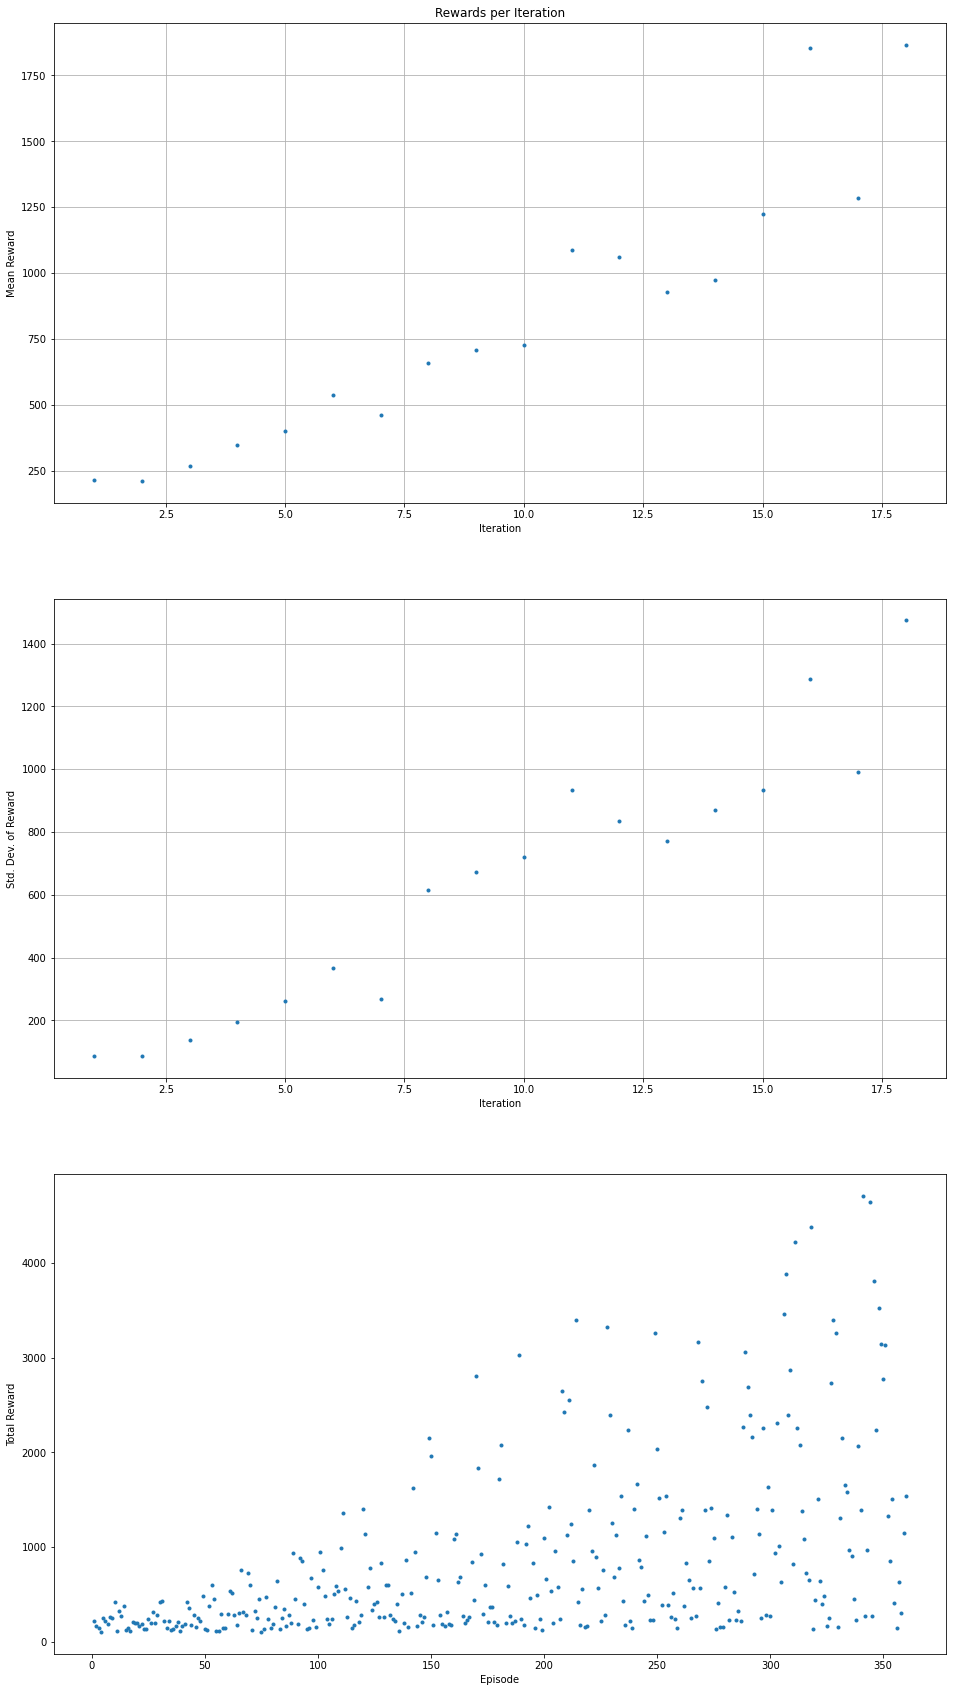

In [30]:
# Reward graph per episode
max_episode = np.max(sim_df['episode'])
max_iteration = np.max(sim_df_iterations['iteration'])
print('Number of episodes = ', max_episode)
print('Number of complete iterations = ', max_iteration)

total_reward_per_episode = list()
for epi in range(1, max_episode + 1):
    df_slice = sim_df[sim_df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == EPISODES_PER_ITERATION:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()

fig = plt.figure(figsize=(16, 10*3))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration))+1, average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration))+1, deviation_reward_per_iteration, '.')
ax.set_ylabel('Std. Dev. of Reward')
ax.set_xlabel('Iteration')
plt.grid(True)

ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode))+1, total_reward_per_episode, '.')
ax.set_ylabel('Total Reward')
ax.set_xlabel('Episode')
plt.grid(False)

# Check Correlation Between Steps and Lap Times
- Plot steps vs lap times to gauge the potential increasae in lap time for every step taken; this can also be used to extrapolate the target number of steps needed in order to achieve a certain lap time

# Check that Rewards Correlate with Performance
- Plot rewards vs lap times as a sanity check for our Reward Function logic

# Determine the Performance Envelope of the Model
- Plot a histogram of lap times to work out statistically the average and best-case lap times (also helps to confirm if the lap times within the performance envelope of the model resembles a normal distribution)
- The -2 and -3 Std Dev markers show the potential best-case lap times for the model

In [31]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
#df_slice = df_slice[df_slice['iteration'] <= 56]
max_iteration = df_slice['iteration'].max()

scatter_size = list()
for iter in df_slice['iteration']:
        if (iter > (max_iteration - 3)):
            scatter_size.append(75)
        else:
            scatter_size.append(5)
    
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=scatter_size, x='elapsed_time', y='steps')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=scatter_size, x='elapsed_time', y='episode_total_rewards')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    w = 0.1
    n = math.ceil((df_slice['elapsed_time'].max() - df_slice['elapsed_time'].min())/w)
    axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='hist', bins=n, x='steps', y='elapsed_time')
    axes.set_xlabel(axes.get_xlabel(), fontsize=20)
    axes.set_ylabel(axes.get_ylabel(), fontsize=20)
    
    data_minus2sd = np.percentile(df_slice['elapsed_time'], 2.28)
    data_minus3sd = np.percentile(df_slice['elapsed_time'], 0.13)

    print('Mean: %f' % (np.mean(df_slice['elapsed_time'])))
    print('Variance: %f' % (np.var(df_slice['elapsed_time'])))
    print('StdDev: %f' % (np.std(df_slice['elapsed_time'])))
    print('-2 StdDev: %f' % (data_minus2sd))
    print('-3 StdDev: %f' % (data_minus3sd))
    
    axes.axvline(x=data_minus2sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus2sd, axes.get_ylim()[1], '-2SD\n(%0.3fs)' % data_minus2sd, ha='right', va='bottom', size=12)

    axes.axvline(x=data_minus3sd,linestyle='dotted',linewidth=0.75,color='black')
    axes.text(data_minus3sd, axes.get_ylim()[1], '\n-3SD \n(%0.3fs) ' % data_minus3sd, ha='right', va='top', size=12)


Completed Episodes: 0


# Identify Potential Model Checkpoints for Cloning and Race Submission
- Plot the top quartile (p25) lap times vs iterations to identify potential model checkpoints and to look out for trade-offs between speed and stability over time
- Use the mean lap times per iteration among the p25 population to see through the noise
- Find the best lap times among the p25 population as an additional consideration

In [32]:
df_slice = sim_df_episodes[sim_df_episodes['status'] == 'lap_complete']
completed_episode_count = df_slice['episode'].count()
print('Completed Episodes: %d' % completed_episode_count)
if completed_episode_count > 0:
    elapsed_time_p25 = df_slice['elapsed_time'].quantile(.25)
    print('p25: %.3fs' % elapsed_time_p25)

    df_slice = df_slice[df_slice['elapsed_time'] <= elapsed_time_p25]
    completed_episode_p25_count = df_slice['episode'].count()
    print('Completed Episodes (p25): %d' % completed_episode_p25_count)
    if completed_episode_p25_count > 0:
        axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='scatter', s=75, x='iteration', y='elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=20)
        axes.set_ylabel(axes.get_ylabel(), fontsize=20)
        
        df_slice["avg_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("mean")
        df_slice["min_elapsed_time"] = df_slice.groupby("iteration")["elapsed_time"].transform("min")

        axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='line', linewidth=5, x='iteration', y='avg_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=20)
        axes.set_ylabel(axes.get_ylabel(), fontsize=20)
        axes.set_title('Avg Elapsed Time', fontsize=20)
        
        axes = df_slice.plot(figsize=(16,10), fontsize=20, kind='line', linewidth=5, x='iteration', y='min_elapsed_time')
        axes.set_xlabel(axes.get_xlabel(), fontsize=20)
        axes.set_ylabel(axes.get_ylabel(), fontsize=20)
        axes.set_title('Min Elapsed Time', fontsize=20)

Completed Episodes: 0


# Plot (Rewards vs Entropy vs Lap Progress) per Iteration

In [33]:
def plot_reward_graph(df_slice_iterations=sim_df_iterations, df_slice_entropy=trn_df_entropy):
    font_size=16
    if(len(df_slice_iterations)>0):
        fig = plt.figure(figsize=(16, 10))
        ax = plt.gca()  # gca stands for 'get current axis'
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

        df_slice_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
        df_slice_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

        df_slice_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

        df_slice_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
        df_slice_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

        ax.legend().remove()
        ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
        ax.set_ylabel('Entropy', fontsize=font_size)

        ax2.legend().remove()
        ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

        start_time = df_slice_iterations["start_time"].min()
        end_time = df_slice_iterations["end_time"].max()
        elapsed_time = end_time - start_time
        elapsed_time_hrs = elapsed_time / 3600
        plt.plot([], [], ' ', label='Iterations: %d' % df_slice_iterations["iteration"].max())
        plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

        fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=14, title="Legend")
        plt.subplots_adjust(bottom=0.15)

        max_rewards_iter = df_slice_iterations['total_rewards_normalized_SMA3'].idxmax()
        if (max_rewards_iter >= 0):
            xmax_rewards = df_slice_iterations['iteration'][max_rewards_iter]
            ymax_rewards = df_slice_iterations['total_rewards_normalized_SMA3'].max()
            plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

        max_progress_iter = df_slice_iterations['avg_progress_SMA3'].idxmax()
        if (max_progress_iter >= 0):
            xmax_progress = df_slice_iterations['iteration'][max_progress_iter]
            ymax_progress = df_slice_iterations['avg_progress_SMA3'].max()
            plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
            plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
            plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

        plt.yticks(np.arange(0, 105, step=10))
        plt.show()
        if (max_rewards_iter >= 0):
            print ("Iteration with Max Total Rewards (SMA3): %d" % (xmax_rewards))
        print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))

# Plot Entropy vs Rewards/Progress as an Additional Indicator for Convergence
- Uses the SMA3 aggregate data to smoothen the graph plot

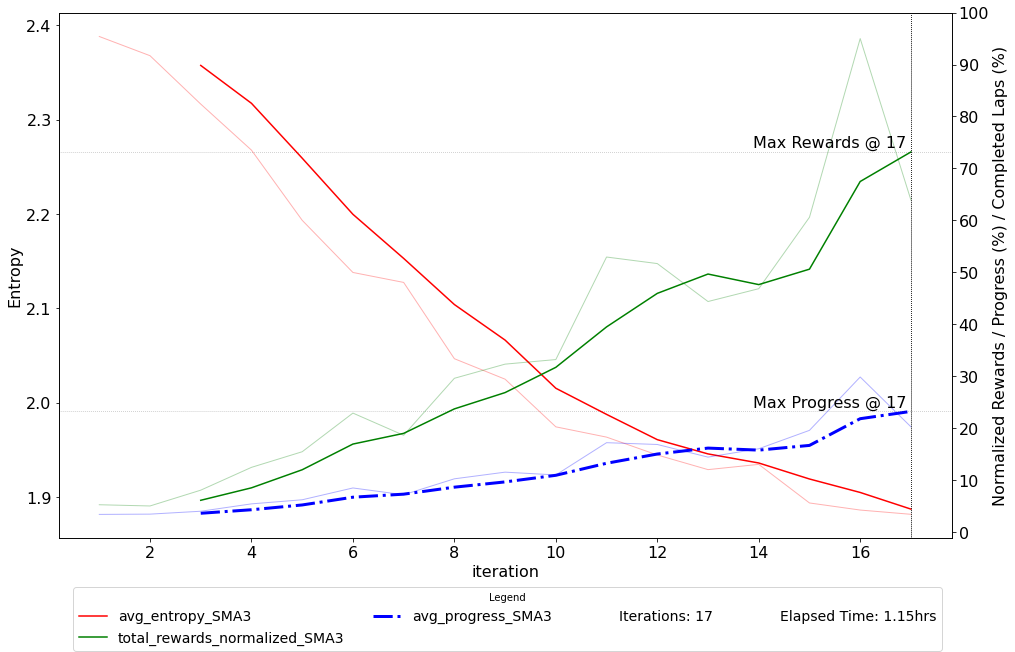

Iteration with Max Total Rewards (SMA3): 17
Elapsed Time: 4123.27s (1.15hrs)


In [34]:
plot_reward_graph()

# Plot the Lap-Completion Ratio of Episodes in Each Iteration to Gauge the Consistency of the Model
- Uses the SMA3 aggregate data to smoothen the graph plot

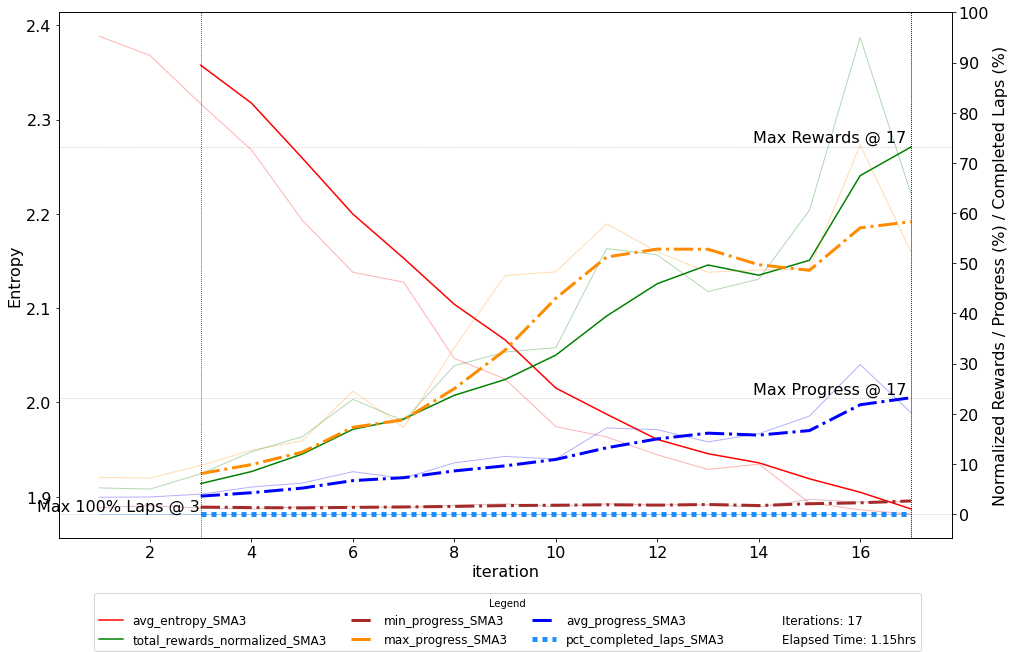

Iteration with Max Pct Completed Laps (SMA3): 3 (Value 0.0)
Iteration with Max Total Rewards (SMA3): 17
Elapsed Time: 4123.27s (1.15hrs)


In [35]:
font_size=16
if(len(sim_df_iterations)>0):
    fig = plt.figure(figsize=(16, 10))
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # force integer labels on x-axis
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    trn_df_entropy.plot(kind='line',x='iteration',y='avg_entropy',label='',linewidth=1,color='red',alpha=0.3,fontsize=font_size,ax=ax)
    trn_df_entropy.plot(kind='line',linestyle='solid',x='iteration',y='avg_entropy_SMA3',linewidth=1.5,color='red',fontsize=font_size,ax=ax)

    sim_df_iterations.plot(kind='line',x='iteration',y='total_rewards_normalized',label='',linewidth=1,color='green',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='solid',x='iteration',y='total_rewards_normalized_SMA3',linewidth=1.5,color='green',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='min_progress',label='',linewidth=1,color='brown',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='min_progress_SMA3',linewidth=3,color='brown',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='max_progress',label='',linewidth=1,color='darkorange',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='max_progress_SMA3',linewidth=3,color='darkorange',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='avg_progress',label='',linewidth=1,color='blue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle='dashdot',x='iteration',y='avg_progress_SMA3',linewidth=3,color='blue',fontsize=font_size,ax=ax2)

    sim_df_iterations.plot(kind='line',x='iteration',y='pct_completed_laps',label='',linewidth=1,color='dodgerblue',alpha=0.3,fontsize=font_size,ax=ax2)
    sim_df_iterations.plot(kind='line',linestyle=(0,(1,1)),x='iteration',y='pct_completed_laps_SMA3',linewidth=5,color='dodgerblue',fontsize=font_size,ax=ax2)

    ax.legend().remove()
    ax.set_xlabel(ax.get_xlabel(), fontsize=font_size)
    ax.set_ylabel('Entropy', fontsize=font_size)
    ax2.legend().remove()
    ax2.set_ylabel('Normalized Rewards / Progress (%) / Completed Laps (%)', fontsize=font_size)

    start_time = sim_df_iterations["start_time"].min()
    end_time = sim_df_iterations["end_time"].max()
    elapsed_time = end_time - start_time
    elapsed_time_hrs = elapsed_time / 3600
    plt.plot([], [], ' ', label='Iterations: %d' % sim_df_iterations["iteration"].max())
    plt.plot([], [], ' ', label='Elapsed Time: %0.2fhrs' % elapsed_time_hrs)

    fig.legend(loc="lower center", borderaxespad=0.1, ncol=4, fontsize=12, title="Legend")
    plt.subplots_adjust(bottom=0.15)

    first_100pct_iteration = sim_df_iterations[sim_df_iterations["max_progress_SMA3"] >= 100.0]['iteration'].min()
    if first_100pct_iteration > 0:
        plt.axvline(x=first_100pct_iteration,linestyle='dotted',linewidth=0.75,color='black')
        plt.gca().text(first_100pct_iteration*0.995, ax2.get_ylim()[0], '100%% Laps @ %d' % first_100pct_iteration, ha='right', va='bottom', size=font_size)

    max_rewards_iter = sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()
    if (max_rewards_iter >= 0):
        xmax_rewards = sim_df_iterations['iteration'][sim_df_iterations['total_rewards_normalized_SMA3'].idxmax()]
        ymax_rewards = sim_df_iterations['total_rewards_normalized_SMA3'].max()
        plt.axvline(x=xmax_rewards,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_rewards,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_rewards*0.995, ymax_rewards*1.005, 'Max Rewards @ %d' % xmax_rewards, ha='right', va='bottom', size=font_size)

    max_progress_iter = sim_df_iterations['avg_progress_SMA3'].idxmax()
    if (max_progress_iter >= 0):
        xmax_progress = sim_df_iterations['iteration'][sim_df_iterations['avg_progress_SMA3'].idxmax()]
        ymax_progress = sim_df_iterations['avg_progress_SMA3'].max()
        plt.axvline(x=xmax_progress,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_progress,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_progress*0.995, ymax_progress*1.005, 'Max Progress @ %d' % xmax_progress, ha='right', va='bottom', size=font_size)

    max_completed_iter = sim_df_iterations['pct_completed_laps_SMA3'].idxmax()
    if (max_completed_iter >= 0):
        xmax_completed_laps = sim_df_iterations['iteration'][sim_df_iterations['pct_completed_laps_SMA3'].idxmax()]
        ymax_completed_laps = sim_df_iterations['pct_completed_laps_SMA3'].max()
        plt.axvline(x=xmax_completed_laps,linestyle='dotted',linewidth=0.75,color='black')
        plt.axhline(y=ymax_completed_laps,linestyle='dotted',linewidth=0.75,color='black',alpha=0.3)
        plt.gca().text(xmax_completed_laps*0.995, ymax_completed_laps*1.005, 'Max 100%% Laps @ %d' % xmax_completed_laps, ha='right', va='bottom', size=font_size)
    
    plt.yticks(np.arange(0, 105, step=10))
    plt.show()

    if (first_100pct_iteration >= 0):
        text= "Iteration with First Completed Laps (SMA3): {:}".format(first_100pct_iteration)
        print(text)

    if (max_completed_iter >= 0):
        text= "Iteration with Max Pct Completed Laps (SMA3): {:} (Value {:})".format(xmax_completed_laps, ymax_completed_laps)
        print(text)

    if (max_rewards_iter >= 0):
        text= "Iteration with Max Total Rewards (SMA3): {:}".format(xmax_rewards)
        print(text)

    print ("Elapsed Time: %0.2fs (%0.2fhrs)" % (elapsed_time, elapsed_time_hrs))


# Load & Visualise the Track Waypoints

If the track is not found, download newer tracks from the [deepracer-simapp bundle](https://github.com/aws-deepracer-community/deepracer-simapp/tree/master/bundle/deepracer_simulation_environment/share/deepracer_simulation_environment/routes) maintained by the community, and copy them into the `tracks` folder

In [36]:
# List the available tracks vs expected WORLD_NAME
print('WORLD_NAME: %s' % WORLD_NAME)
ListFiles = [f for f in listdir("tracks/") if isfile(join("tracks/", f))]
ListFiles
print('Available Tracks: %s' % ListFiles)

WORLD_NAME: thunder_hill_pro
Available Tracks: ['reInvent2019_track.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'AmericasGeneratedInclStart.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'Belille.npy', 'H_track.npy', 'reinvent_base.npy', 'Mexico_track.npy', 'Spain_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'Albert.npy', 'China_track.npy', 'LGSWide.npy', 'July_2020.npy', 'FS_June2020.npy', 'London_Loop_Train.npy', 'ChampionshipCup2019_track.npy']


In [37]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints(WORLD_NAME)
waypoints.shape

FileNotFoundError: [Errno 2] No such file or directory: 'tracks/thunder_hill_pro.npy'

In [90]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

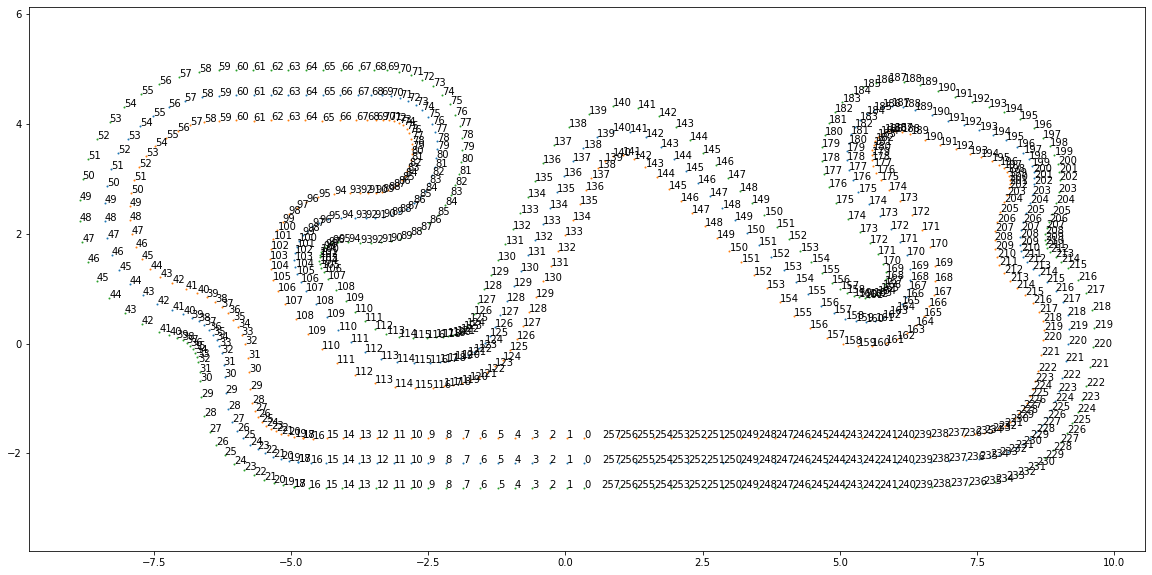

In [91]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

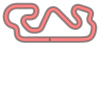

In [92]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
road_poly

In [93]:
# rescale waypoints to centimeter scale
center_line = waypoints[:,0:2] *100
inner_border = waypoints[:,2:4] *100
outer_border = waypoints[:,4:6] *100

In [94]:
# add x_offset to bring everything to the positive axis

x_offset = int(sim_df['x'].min())
if x_offset > 0: # if positive, just keep it the same
    x_offset = 0
x_offset = abs(x_offset)

inner_border[:,:] = inner_border[:,:] + x_offset
center_line[:,:] = center_line[:,:] + x_offset
outer_border[:,:] = outer_border[:,:] + x_offset


In [95]:
# add y_offset to bring everything to the positive axis

y_offset = int(sim_df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,1] = inner_border[:,1] + y_offset - x_offset
center_line[:,1] = center_line[:,1] + y_offset - x_offset
outer_border[:,1] = outer_border[:,1] + y_offset - x_offset

In [96]:
# track dimensions
track_x_max = outer_border[:,:].max()
track_y_max = outer_border[:,1].max()
print ('Track Dimensions: (%f, %f)' % (track_x_max, track_y_max))

# simulation dimensions
sim_x_max = sim_df['x'].max() + x_offset
sim_y_max = sim_df['y'].max() + y_offset
print ('Simulation Dimensions: (%f, %f)' % (sim_x_max, sim_y_max))

# plot dimensions
plot_x_max = int(math.ceil(max(track_x_max, sim_x_max)/50) * 50)
plot_y_max = int(math.ceil(max(track_y_max, sim_y_max)/50) * 50)
print ('Plot Dimensions: (%d, %d)' % (plot_x_max, plot_y_max))

Track Dimensions: (1864.849354, 777.790503)
Simulation Dimensions: (1884.480000, 795.630000)
Plot Dimensions: (1900, 800)


In [97]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

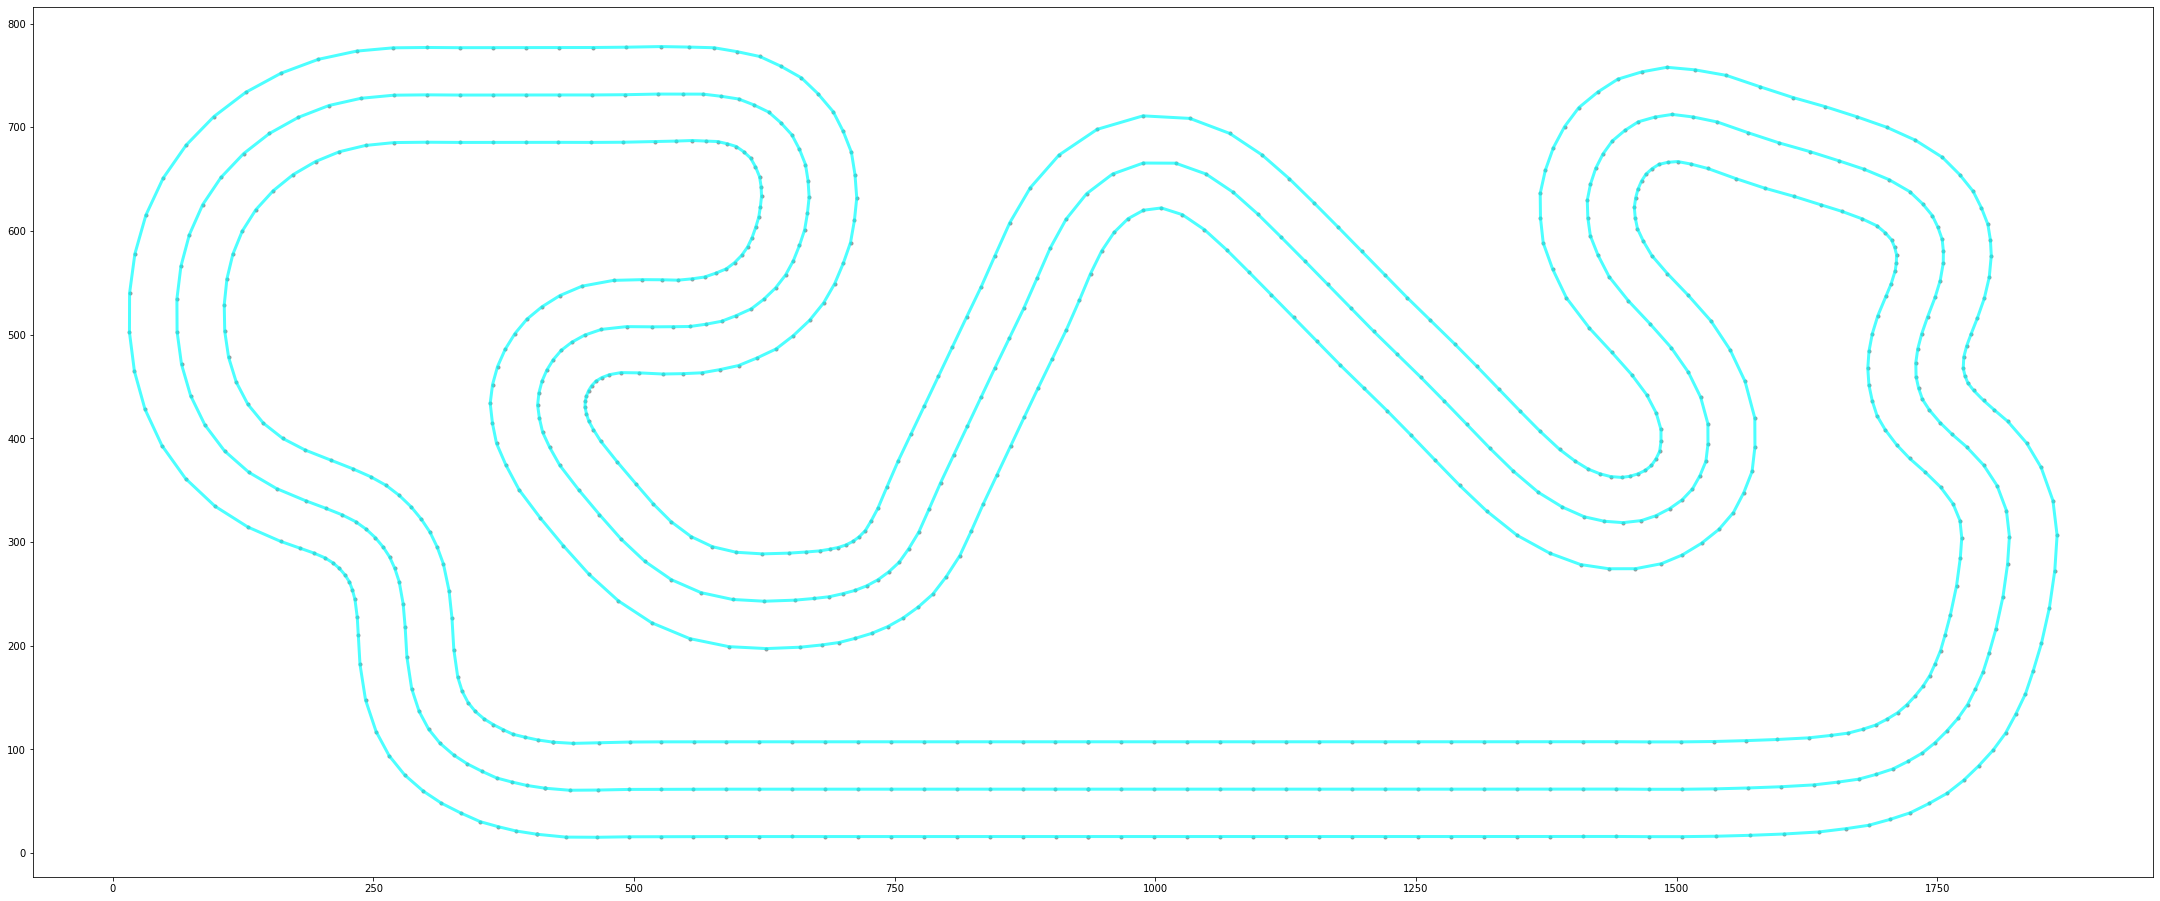

In [98]:
# Plot the track layout with the right scale and size

fig = plt.figure(figsize=(plot_x_max/50, plot_y_max/50))
ax = fig.add_subplot(111)
print_border(ax, center_line, inner_border, outer_border)

# Plot Actions Utilisation Heatmap for the Most Recent Iteration to Tweak the Action Space
- Use a heatmap to visualise the relative use of each action in the action space, in order to identify actions to consolidate / remove

In [99]:
def plot_count_on_action(df):
    actionspace = np.zeros((int((action_max_speed+(action_min_speed/3)) * 10 * 1.1), int(action_steering_range * 1.1)))
    for index, row in df.iterrows():
        x = int(row["steer"])+(int(action_steering_range * 1.1 / 2))
        y = int(row["throttle"]*10)
        actionspace[y,x] += 1
        
    fig = plt.figure(1, figsize=(16,10))
    ax = fig.add_subplot(111)
    return actionspace

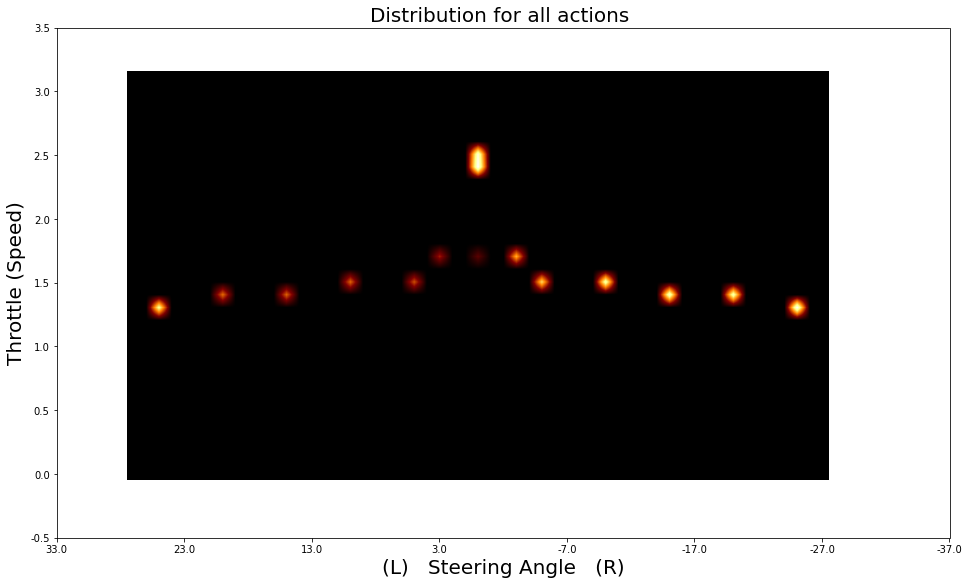

In [100]:
max_iteration = sim_df['iteration'].max()
df_slice = sim_df[sim_df['iteration'] == max_iteration]

track = plot_count_on_action(df_slice)
plt.title("Distribution for all actions ", fontsize=20)
im = plt.imshow(track, cmap='afmhot', interpolation='bilinear', origin="lower") 

ax = plt.gca()  # gca stands for 'get current axis'
ax.set_xlabel('(L)   Steering Angle   (R)', fontsize=20)
ax.set_ylabel('Throttle (Speed)', fontsize=20)

xlabels = ax.get_xticks()
ax.set_xticks(xlabels)
new_xlabels = [(x-int(action_steering_range * 1.1 / 2)) for x in xlabels]
ax.xaxis.set_ticklabels(new_xlabels)
ax.set_xlim(xlabels[-1], xlabels[0])

ylabels = ax.get_yticks()
ax.set_yticks(ylabels)
new_ylabels = [(y/10) for y in ylabels]    
ax.yaxis.set_ticklabels(new_ylabels)

plt.show()

# Plot Avg Speed and Steering at Each Waypoint (Horizontal) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (horizontally), to identify inefficiencies in driving behaviour

In [101]:
def plot_speedsteering_per_waypoint_h(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(25.6, 16))
    
    plt.xticks(np.arange(0, max_waypoint+1, 10.0), fontsize=20)
    plt.xlabel('\nWaypoint', fontsize=20)
    plt.yticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=20)
    plt.ylabel('(L)   Steering Angle   (R)\n\n\n', fontsize=20, rotation=270)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xticks(np.arange(5, max_waypoint+1, 10.0), minor=True)
    ax.tick_params(axis='x', which='major', length=10, direction='inout')
    ax.tick_params(axis='x', which='minor', length=5, direction='in')
    ax.set_ylim(math.floor(-max_steering), math.ceil(max_steering))
    ax.set_yticks(np.arange(math.floor(-max_steering)+1, math.ceil(max_steering)+1, 1.0), minor=True)
    ax.tick_params(axis='y', which='major', length=10, direction='inout')
    ax.tick_params(axis='y', which='minor', length=5, direction='in')


    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('\n\n\nThrottle', fontsize=20, rotation=270)
    ax2.set_ylim(-max_speed, max_speed)
    ax2.set_yticks(np.arange(0, max_speed+0.5, 0.5))
    ax2.set_yticks(np.arange(0.1, max_speed+0.1, 0.1), minor=True)
    ax2.tick_params(axis='y', which='major', length=10, direction='inout', labelsize=20)
    ax2.tick_params(axis='y', which='minor', length=5, direction='in')

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [wp, wp]
            y = [0, avg_steering_angle]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([wp, wp], [0, 0], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [wp, wp]
            y = [-avg_speed, avg_speed]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([wp, wp], [0, 0], marker = 'x', color='red', alpha=0.5, linewidth=1)




max_waypoint: 258


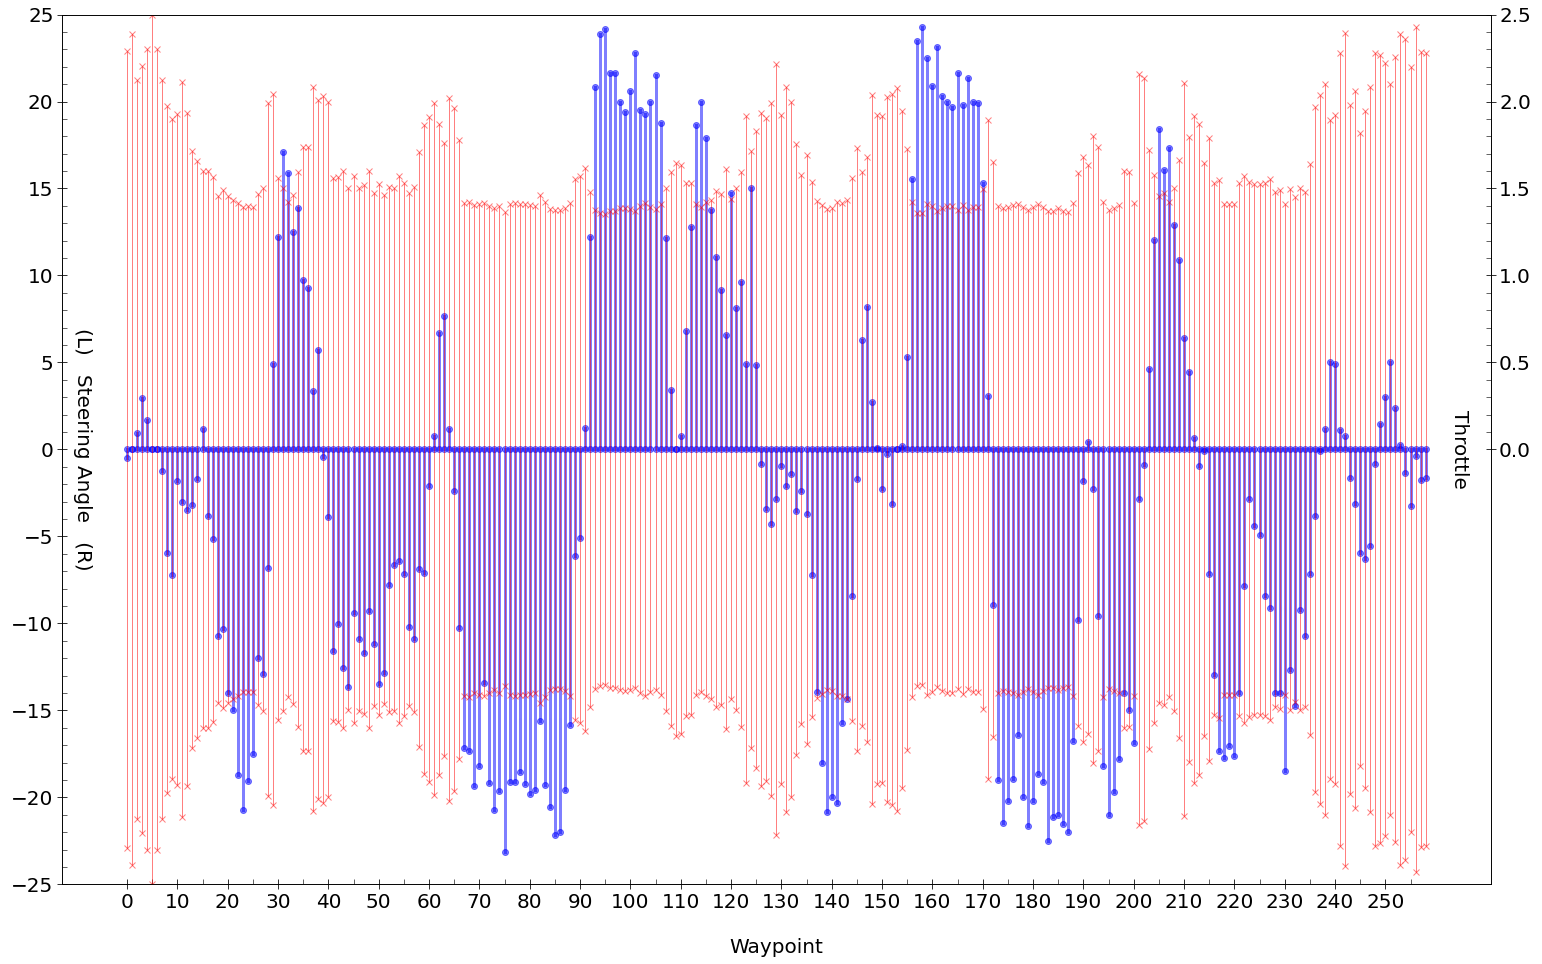

In [102]:
max_iteration = sim_df['iteration'].max()
plot_speedsteering_per_waypoint_h(sim_df[sim_df['iteration']==max_iteration])

# Plot Avg Speed and Steering at Each Waypoint (Vertical) for the Most Recent Iteration
- Visualise the Avg Speed and Steering Angle at each waypoint (vertically), to identify inefficiencies in driving behaviour

In [103]:
def plot_speedsteering_per_waypoint_v(df):
    max_waypoint = df['closest_waypoint'].max()
    print ('max_waypoint: %d' % max_waypoint)
    
    max_steering = max(abs(df['steer'].min()), abs(df['steer'].max()))
    max_speed = df['throttle'].max()
    fig = plt.figure(figsize=(16, max_waypoint/10))
    
    plt.yticks(np.arange(0, max_waypoint+1, 5.0), fontsize=12)
    plt.ylabel('Waypoint\n', fontsize=20)
    plt.xticks(np.arange(math.floor(-max_steering), math.ceil(max_steering)+1, 5.0), fontsize=12)
    plt.xlabel('\n(L)   Steering Angle   (R)', fontsize=20)
    
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.set_xlim(math.ceil(max_steering), math.floor(-max_steering))

    ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
    ax2.set_xlabel('Throttle\n', fontsize=20)
    ax2.set_xlim(-max_speed, max_speed)
    ax2.set_xticks(np.arange(0, max_speed+0.5, 0.5))

    wp_steering = list(range(max_waypoint + 1))
    wp_steering_count = list(range(max_waypoint + 1))
    wp_speed = list(range(max_waypoint + 1))
    wp_speed_count = list(range(max_waypoint + 1))
    
    for wp in range(0, max_waypoint+1):
        wp_steering[wp] = 0
        wp_steering_count[wp] = 0
        wp_speed[wp] = 0
        wp_speed_count[wp] = 0

    for index, row in df.iterrows():
        closest_waypoint = row['closest_waypoint']
        steering_angle = row['steer']
        wp_steering[closest_waypoint] += steering_angle
        wp_steering_count[closest_waypoint] += 1
        speed = row['throttle']
        wp_speed[closest_waypoint] += (speed)
        wp_speed_count[closest_waypoint] += 1
        
    for wp in range(0, max_waypoint+1):
        if (wp_steering_count[wp]>0):
            avg_steering_angle = wp_steering[wp] / wp_steering_count[wp]
            x = [0, avg_steering_angle]
            y = [wp, wp]
            ax.plot(x, y, marker = 'o', color='blue', alpha=0.5, linewidth=3)
        else:
            ax.plot([0, 0], [wp, wp], marker = 'o', color='blue', alpha=0.5, linewidth=3)
        if (wp_speed_count[wp]>0):
            avg_speed = wp_speed[wp] / wp_speed_count[wp]
            x = [-avg_speed, avg_speed]
            y = [wp, wp]
            ax2.plot(x, y, marker = 'x', color='red', alpha=0.5, linewidth=1)
        else:
            ax2.plot([0, 0], [wp, wp], marker = 'x', color='red', alpha=0.5, linewidth=1)



max_waypoint: 258


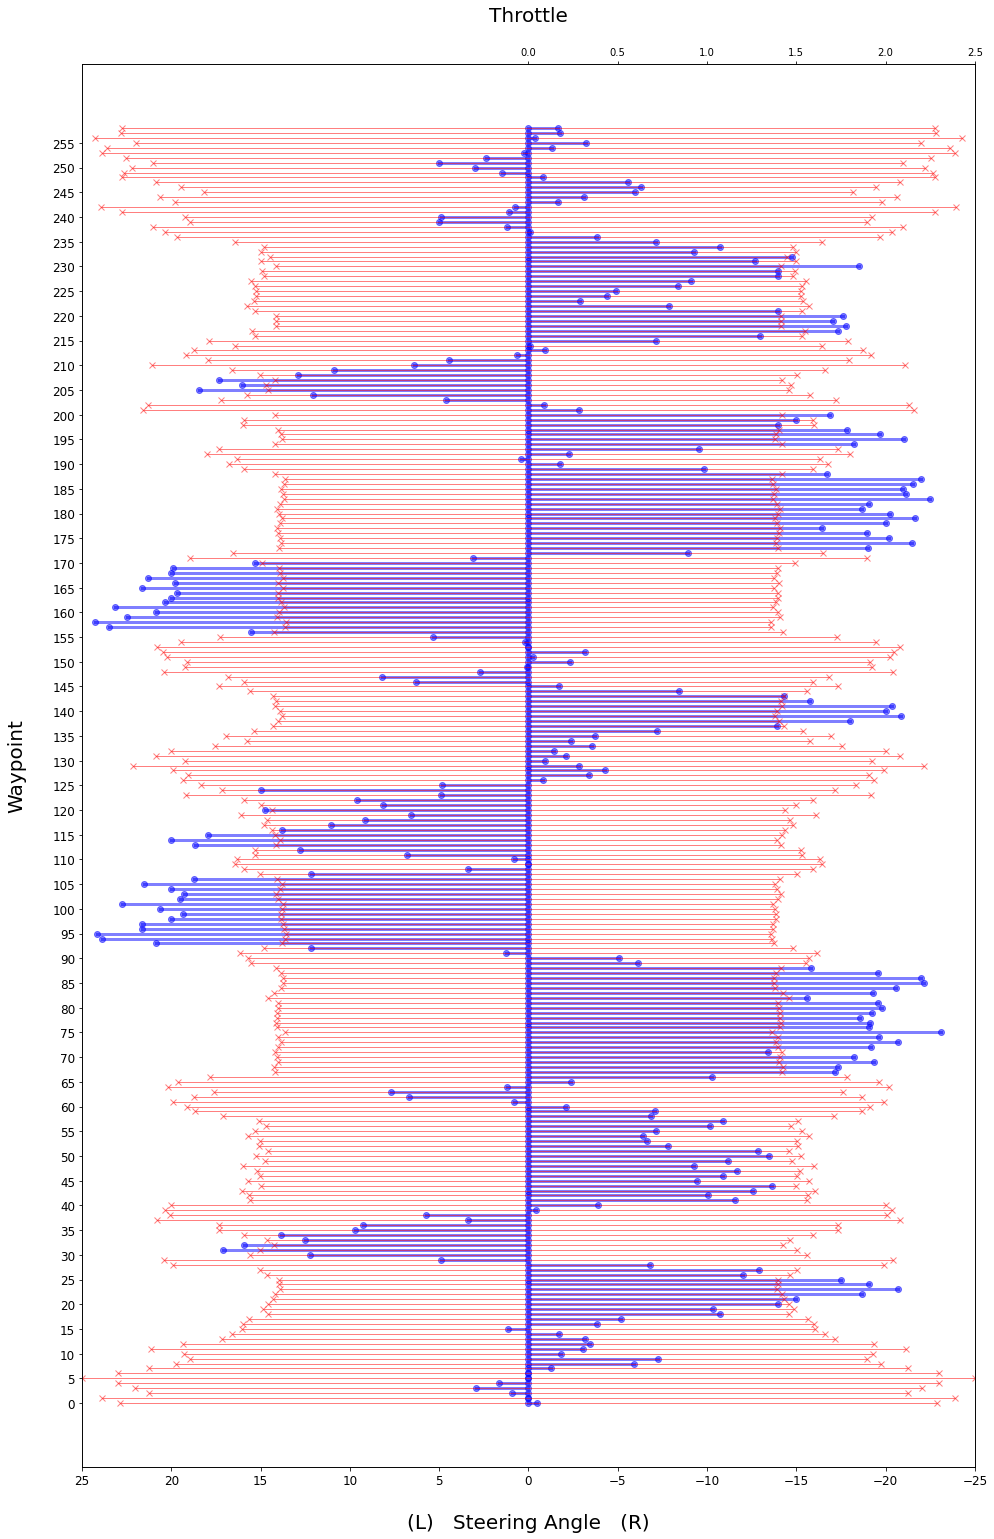

In [104]:
max_iteration = sim_df['iteration'].max()
plot_speedsteering_per_waypoint_v(sim_df[sim_df['iteration']==max_iteration])

# Plot Action / Reward Distribution Heatmap on Track

In [105]:
def plot_x_top_speed_y_top_angle_on_track(df, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''

    x_highest_speed = 0.0
    if speed_index != 0:
        action_speed_list = action_speed
        action_speed_list.sort()
        x_highest_speed = action_speed_list[-speed_index]
        print('Speed - X Highest: X=%d (%f)' % (speed_index, x_highest_speed))

    y_highest_angle = 0.0
    if angle_index != 0:
        action_steering_list = action_steering
        action_steering_list.sort()
        y_highest_angle = action_steering_list[-angle_index]
        print('Absolute Angle - Y Highest: Y=%d (%f)' % (angle_index, y_highest_angle))
    
    if less_equal_angle >= 0:
        print('Absolute Angle - Less Or Equal: %d' % (less_equal_angle))
        
    if exact_angle != 0:
        print('Absolute Angle - Exact: %d' % (exact_angle))        

    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"]) + x_offset
        y = int(row["y"]) + y_offset
        reward = row["reward"]
        throttle = row["throttle"]
        steer = row["steer"]
        
        if ((throttle == x_highest_speed) or (speed_index == 0)) and ((abs(steer) == y_highest_angle) or (angle_index == 0)) and ((abs(steer) <= less_equal_angle) or (less_equal_angle < 0)) and ((abs(steer) == exact_angle) or (exact_angle == 0)):
            if (plot_reward == True):
                track[y,x] = reward
            else:
                track[y,x] = 1
        
    fig = plt.figure(1, figsize=(plot_x_max/50, plot_y_max/50))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [106]:
def plot_x_top_speed_y_top_angle_on_track_for_iteration(curr_iteration, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward):
    max_iteration = sim_df['iteration'].max()
    if (curr_iteration == 0):
        curr_iteration = max_iteration
    df_slice = sim_df[sim_df['iteration']<=curr_iteration]
    df_slice = df_slice[df_slice['iteration']>(curr_iteration-5)]

    track = plot_x_top_speed_y_top_angle_on_track(df_slice, speed_index, angle_index, less_equal_angle, exact_angle, plot_reward, track_size=(plot_y_max, plot_x_max), x_offset=x_offset, y_offset=y_offset)
    title_prefix = ''
    if (plot_reward == True):
        title_prefix = 'Reward '
    plt.title("%sDistribution for X Highest Speed & Y Highest Angle\nAngle Less or Eq to Z & Eq to W\nX: %d / Y: %d / Z: %d / W: %d" % (title_prefix, speed_index, angle_index, less_equal_angle, exact_angle))
    im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

# Plot Reward Distribution Heatmap on Track for the Most Recent Iteration
- Verify that we're not rewarding for bad driving behaviour
- Overlay a heatmap of rewards on the track to identify areas of improvement for the Reward Function; this could also highlight sections where the car is over- and under-steering, or where the car is not driving smoothly

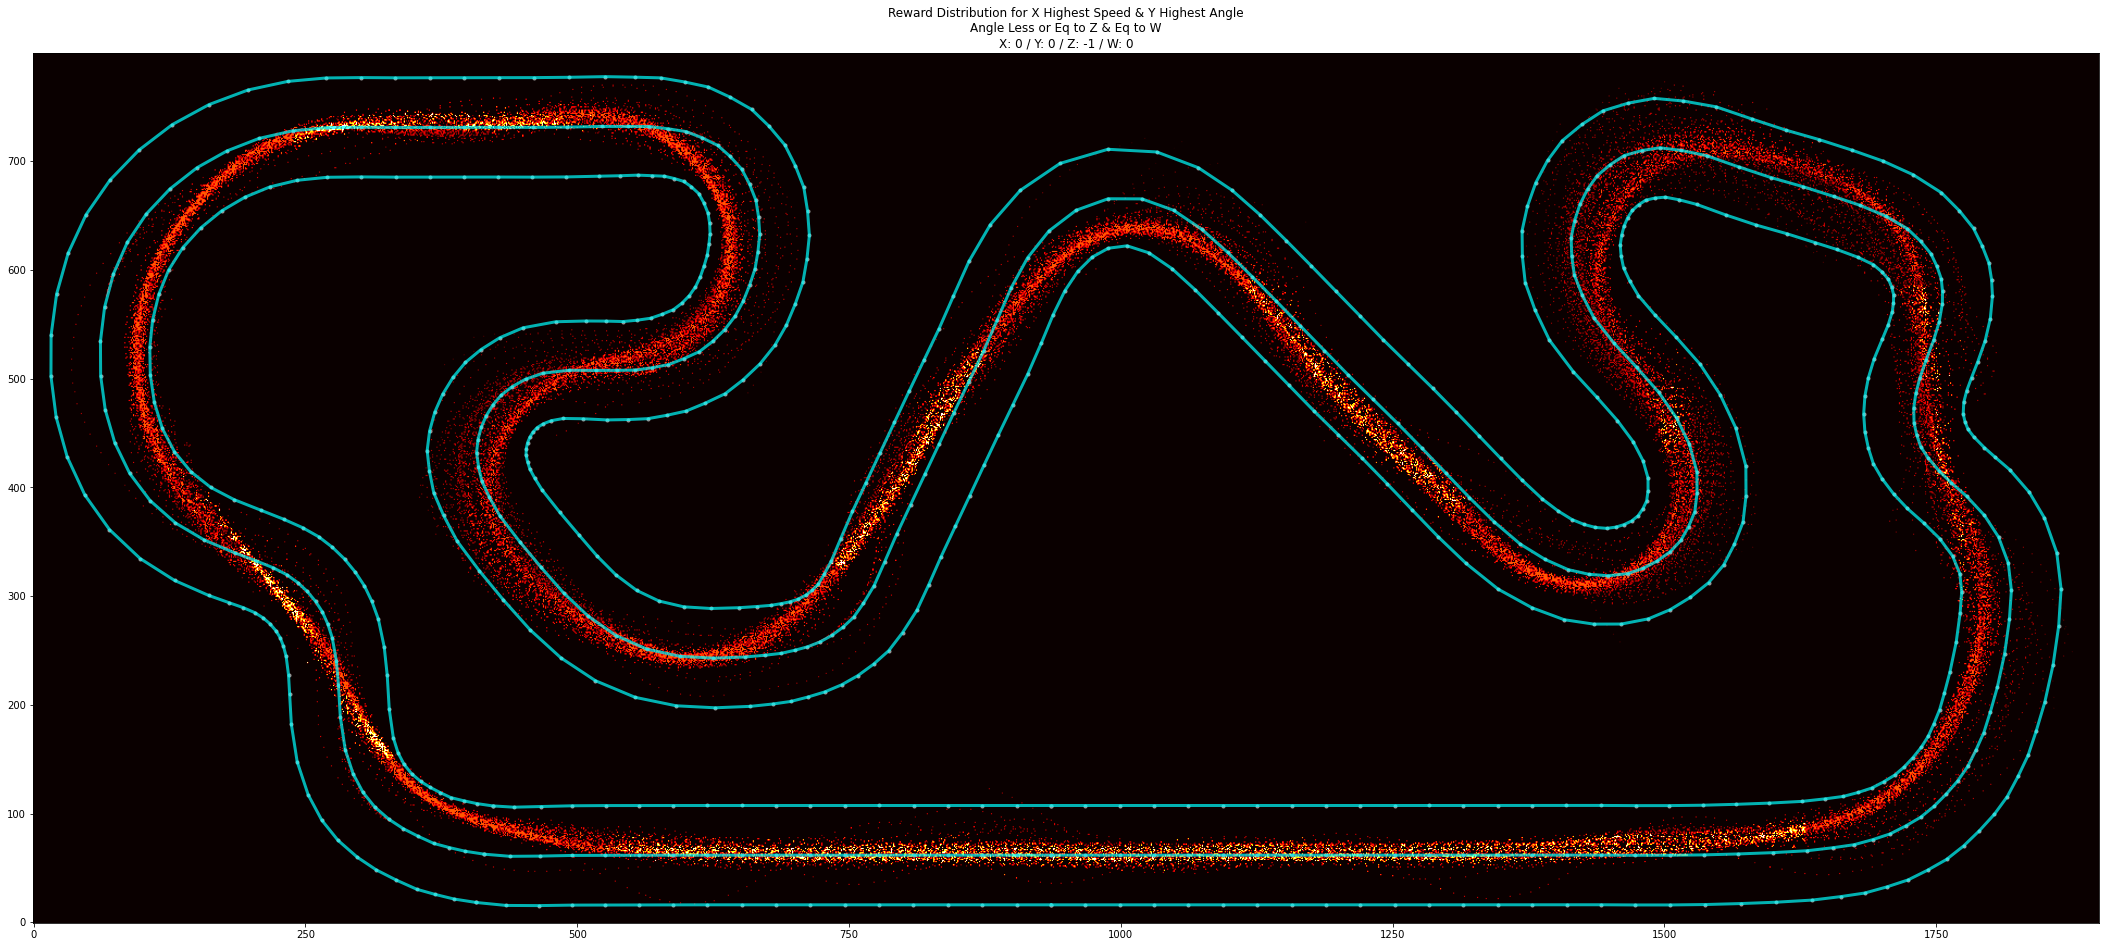

In [107]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, -1, 0, True)

# Plot Highest-Speed Action Distribution Heatmap on Track for the Most Recent Iteration
- Verify that the model uses the highest speed at appropriate sections of the track (eg., on straights)

Speed - X Highest: X=1 (2.500000)


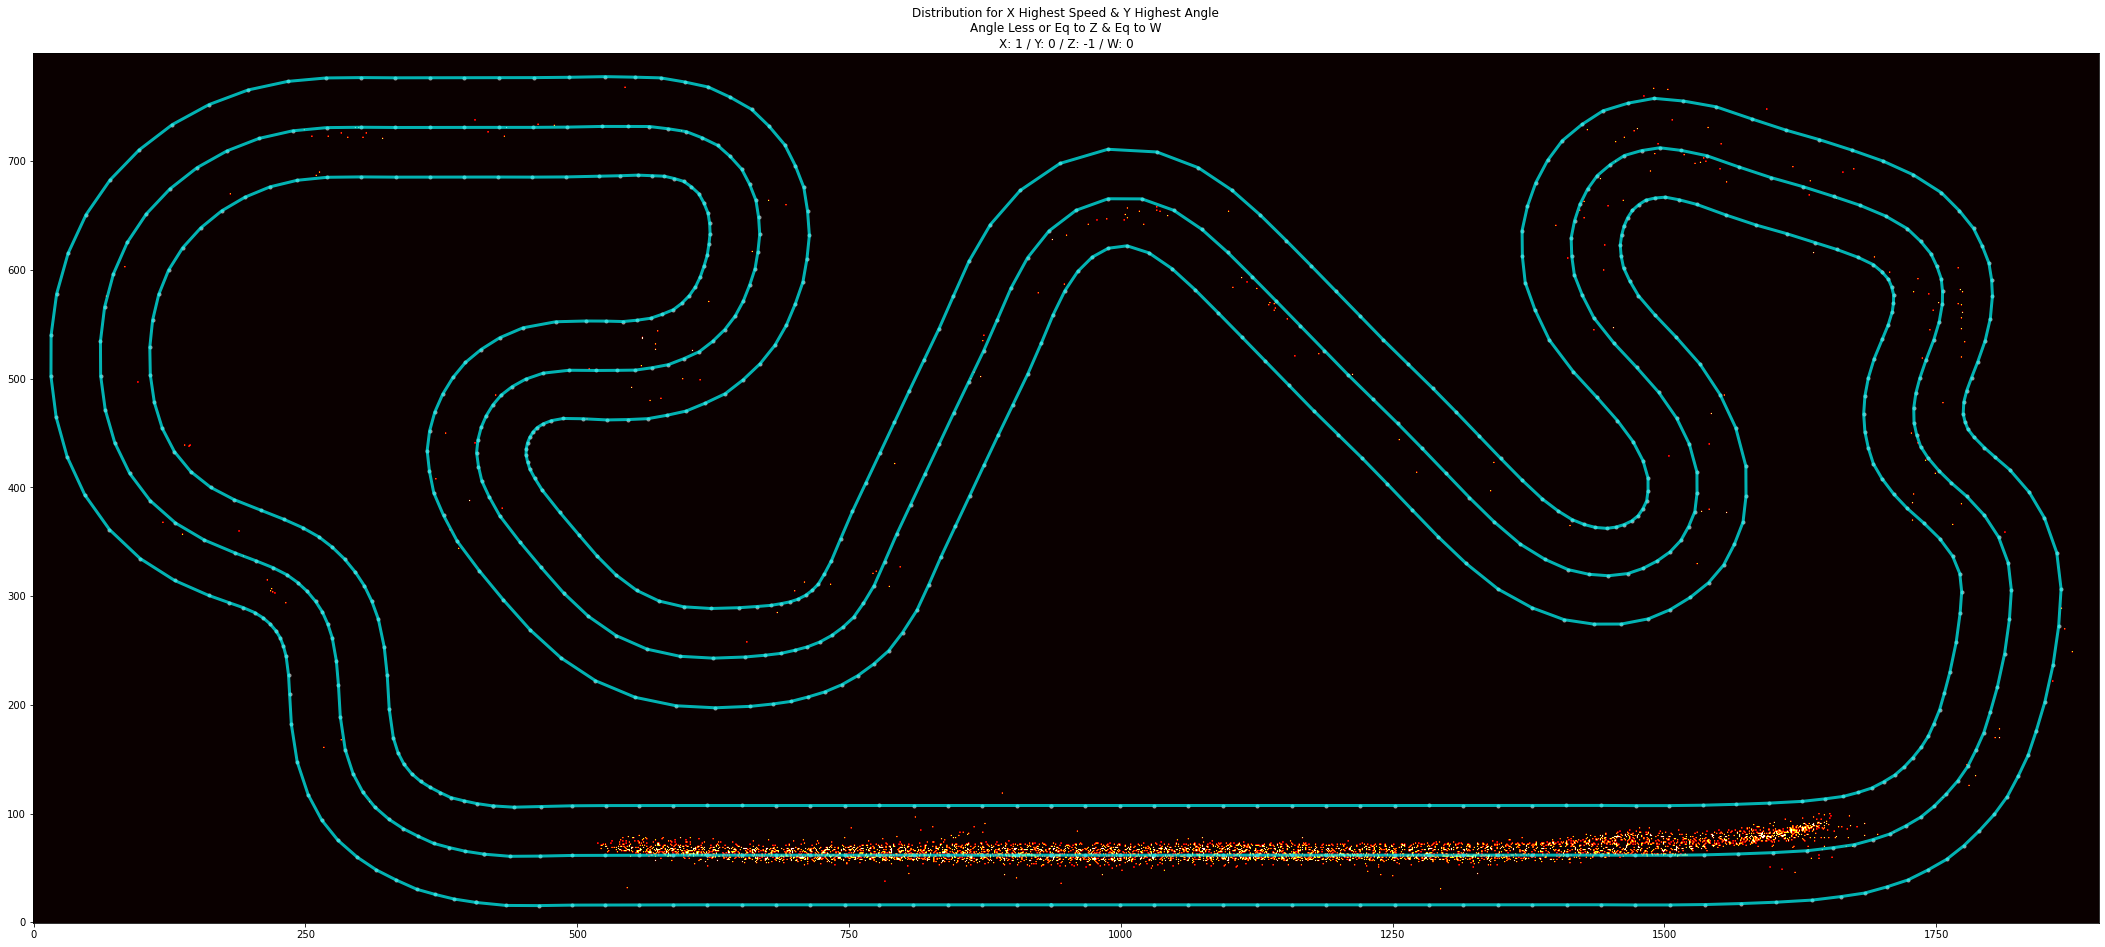

In [108]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 1, 0, -1, 0, False)

# Plot 0-Degree Steering Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is driving straight, to identify sections where we could potentially tweak the actions / rewards

Absolute Angle - Less Or Equal: 0


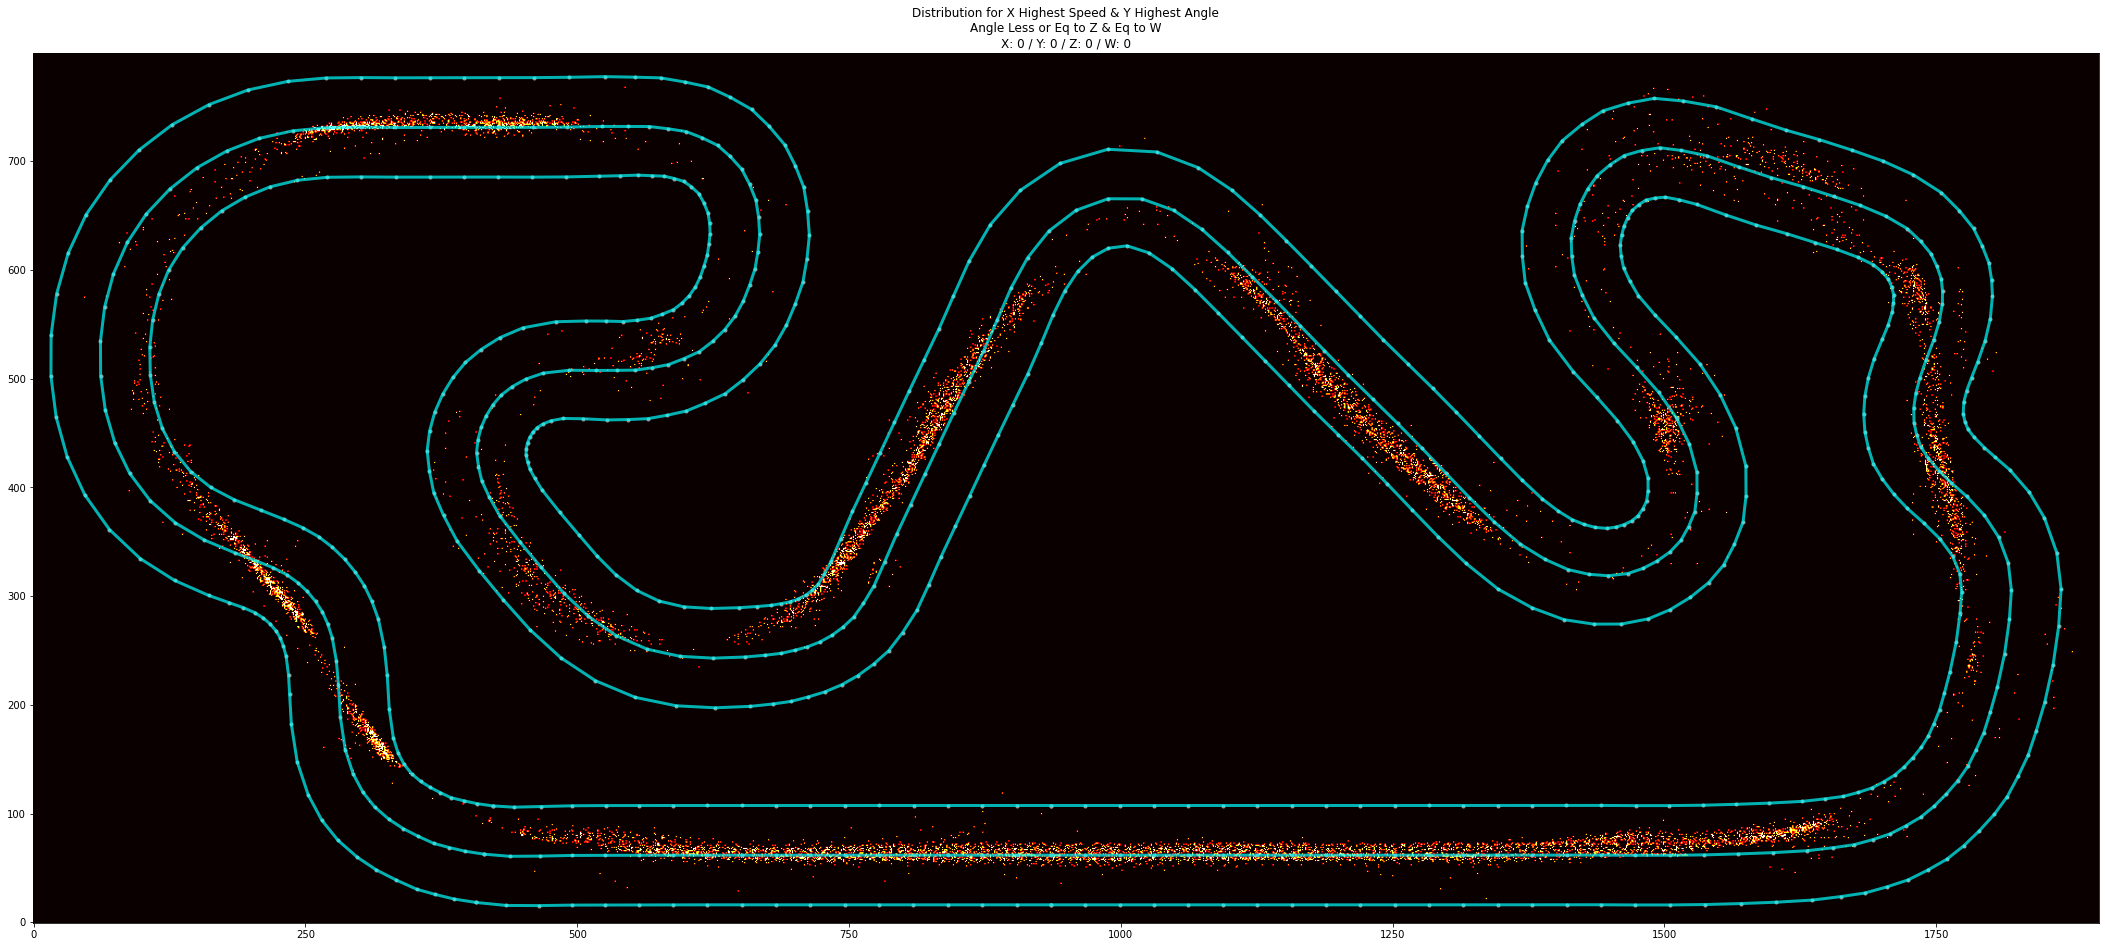

In [109]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 0, 0, 0, False)

# Plot Widest Steering-Angle Distribution Heatmap on Track for the Most Recent Iteration
- Analyse the various sections of the track where the model is steering heavily, to identify sections where we could potentially tweak the actions / rewards
- Assumes there are symmetrical -ve and +ve steering angles (otherwise this would plot only the side that has the biggest absolute steering angle value)

Absolute Angle - Y Highest: Y=1 (25.000000)


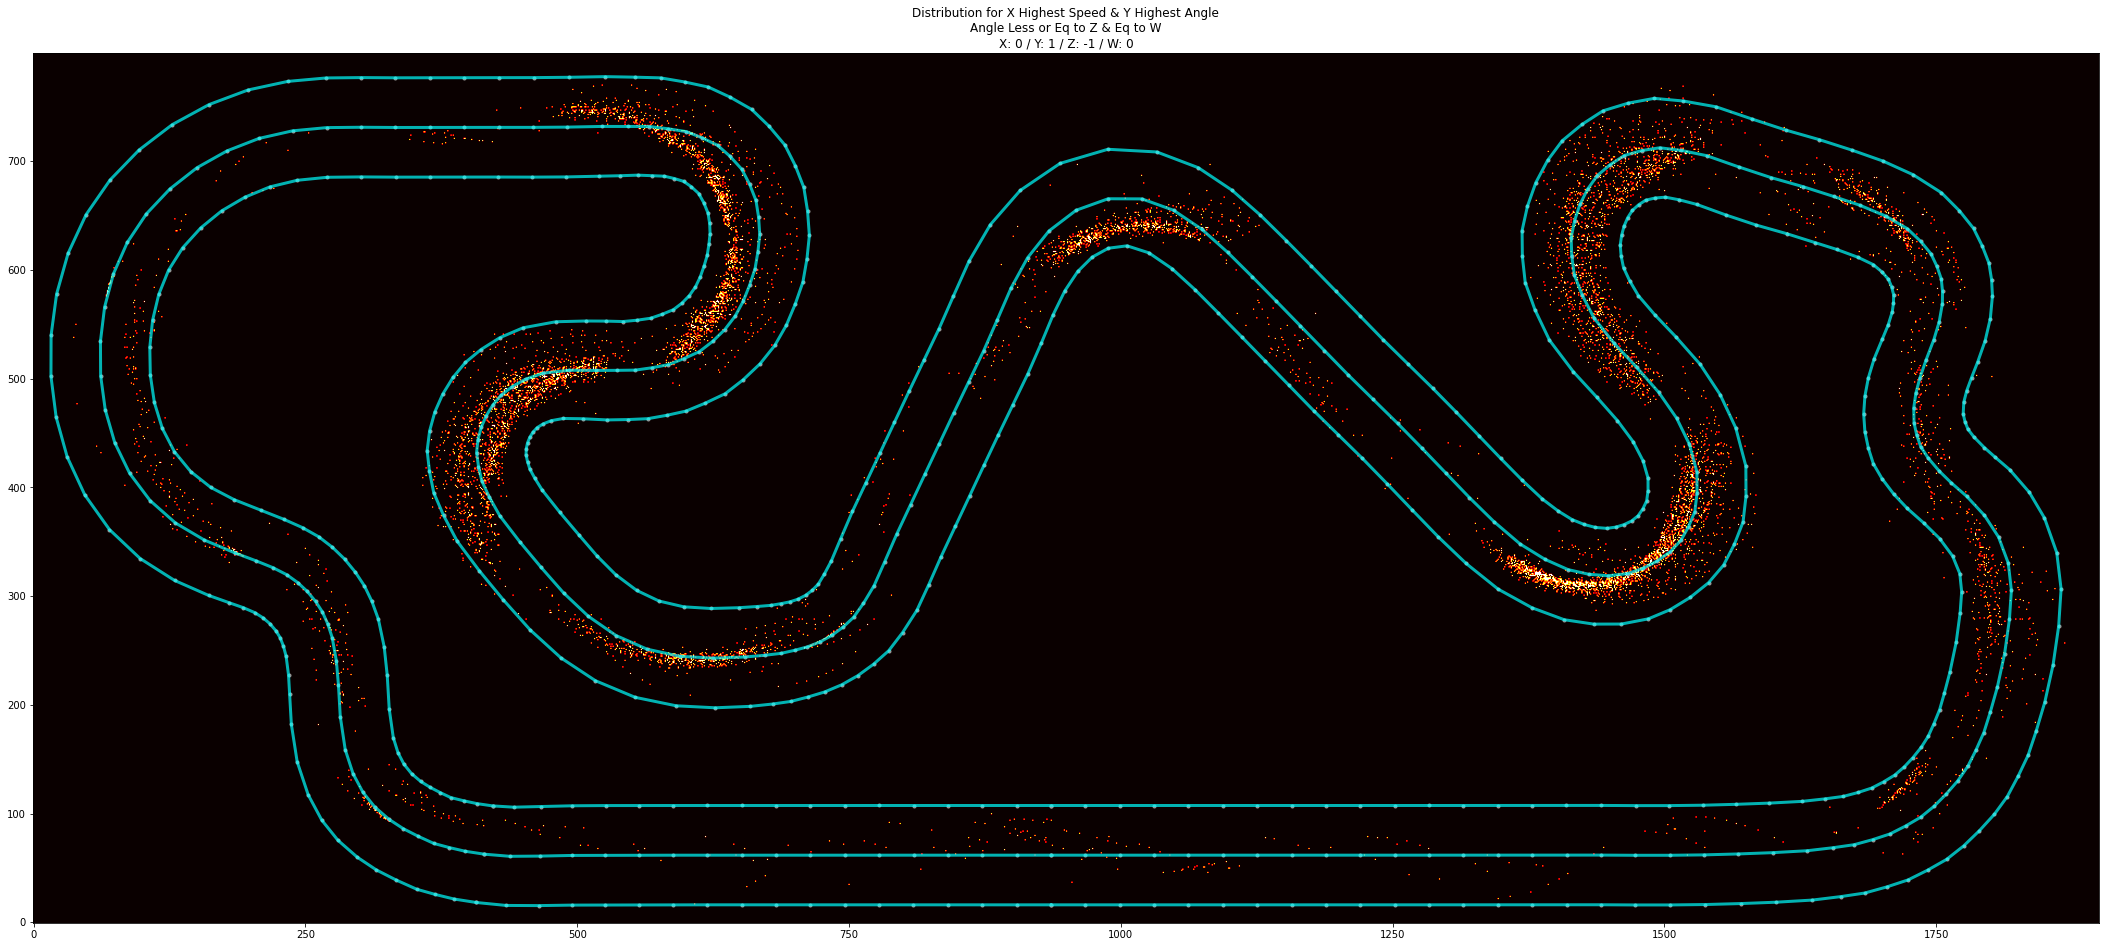

In [110]:
max_iteration = sim_df['iteration'].max()
plot_x_top_speed_y_top_angle_on_track_for_iteration(max_iteration, 0, 1, -1, 0, False)

# Plot Path Taken for the Fastest Completed Lap

In [111]:
def plot_top_laps(sorted_idx, n_laps=5, x_offset=0, y_offset=0, plot_yaw=False, plot_steer=False, plot_labels=False):
    fig = plt.figure(n_laps, figsize=(plot_x_max/50, plot_y_max/50*n_laps))
    for i in range(n_laps):
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        idx = sorted_idx[i]
        episode_data = sim_df[sim_df['episode']==idx]
        episode = sim_df_episodes[sim_df_episodes['episode']==idx]

        plt.title('Episode: %s (Iteration: %d, Episode-in-Iteration: %d), Steps: %d, Progress: %.2f, Rewards: %.2f, Elapsed Time: %.2fs, Status: %s' % (idx, episode['iteration'], episode['episode_in_iteration'], episode['steps'], episode['progress'], episode['episode_total_rewards'], episode['elapsed_time'], episode['status'].values[0]))
        for index, row in episode_data.iterrows():
            x1 = row['x']
            y1 = row['y']
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1+x_offset, car_x2+x_offset], [y1+y_offset, car_y2+y_offset], 'b.')
            
            if (plot_yaw):
                dx = 5*row['throttle']*math.cos(row['yaw']*math.pi/180)
                dy = 5*row['throttle']*math.sin(row['yaw']*math.pi/180)
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc='b', ec='b', zorder=99)
    
            if (plot_steer):
                dx = 5*row['throttle']*math.cos((row['yaw']+row['steer'])*math.pi/180)
                dy = 5*row['throttle']*math.sin((row['yaw']+row['steer'])*math.pi/180)
                if row['steer'] < 0:
                    steer_color = 'r'
                elif row['steer'] > 0:
                    steer_color = 'lime'
                else:
                    steer_color = 'y'
                plt.arrow(x1+x_offset, y1+y_offset, dx, dy, linewidth=1, head_width=8, head_length=5, fc=steer_color, ec=steer_color, zorder=99)

            if (plot_labels):
                label_txt = '  STP: %s, WP: %s, HD:%0.2f, STR:%s, THR:%s' % (row['steps'], row['closest_waypoint'], row['yaw'], row['steer'], row['throttle'])
                plt.text(x1+x_offset, y1+y_offset, label_txt)
                print(label_txt)
    return fig



In [112]:
sim_df_episodes_fastest_full_lap = sim_df_episodes[sim_df_episodes['progress']>=100.0].sort_values('elapsed_time', ascending=True).head(1)
sim_df_episodes_fastest_full_lap

,iteration,episode_in_iteration,episode,steps,progress,status,episode_total_rewards,elapsed_time,start_time,end_time
789341,89,30,3550,465,100.0,lap_complete,2206.8823,31.097813,1.589284e+09,1.589285e+09


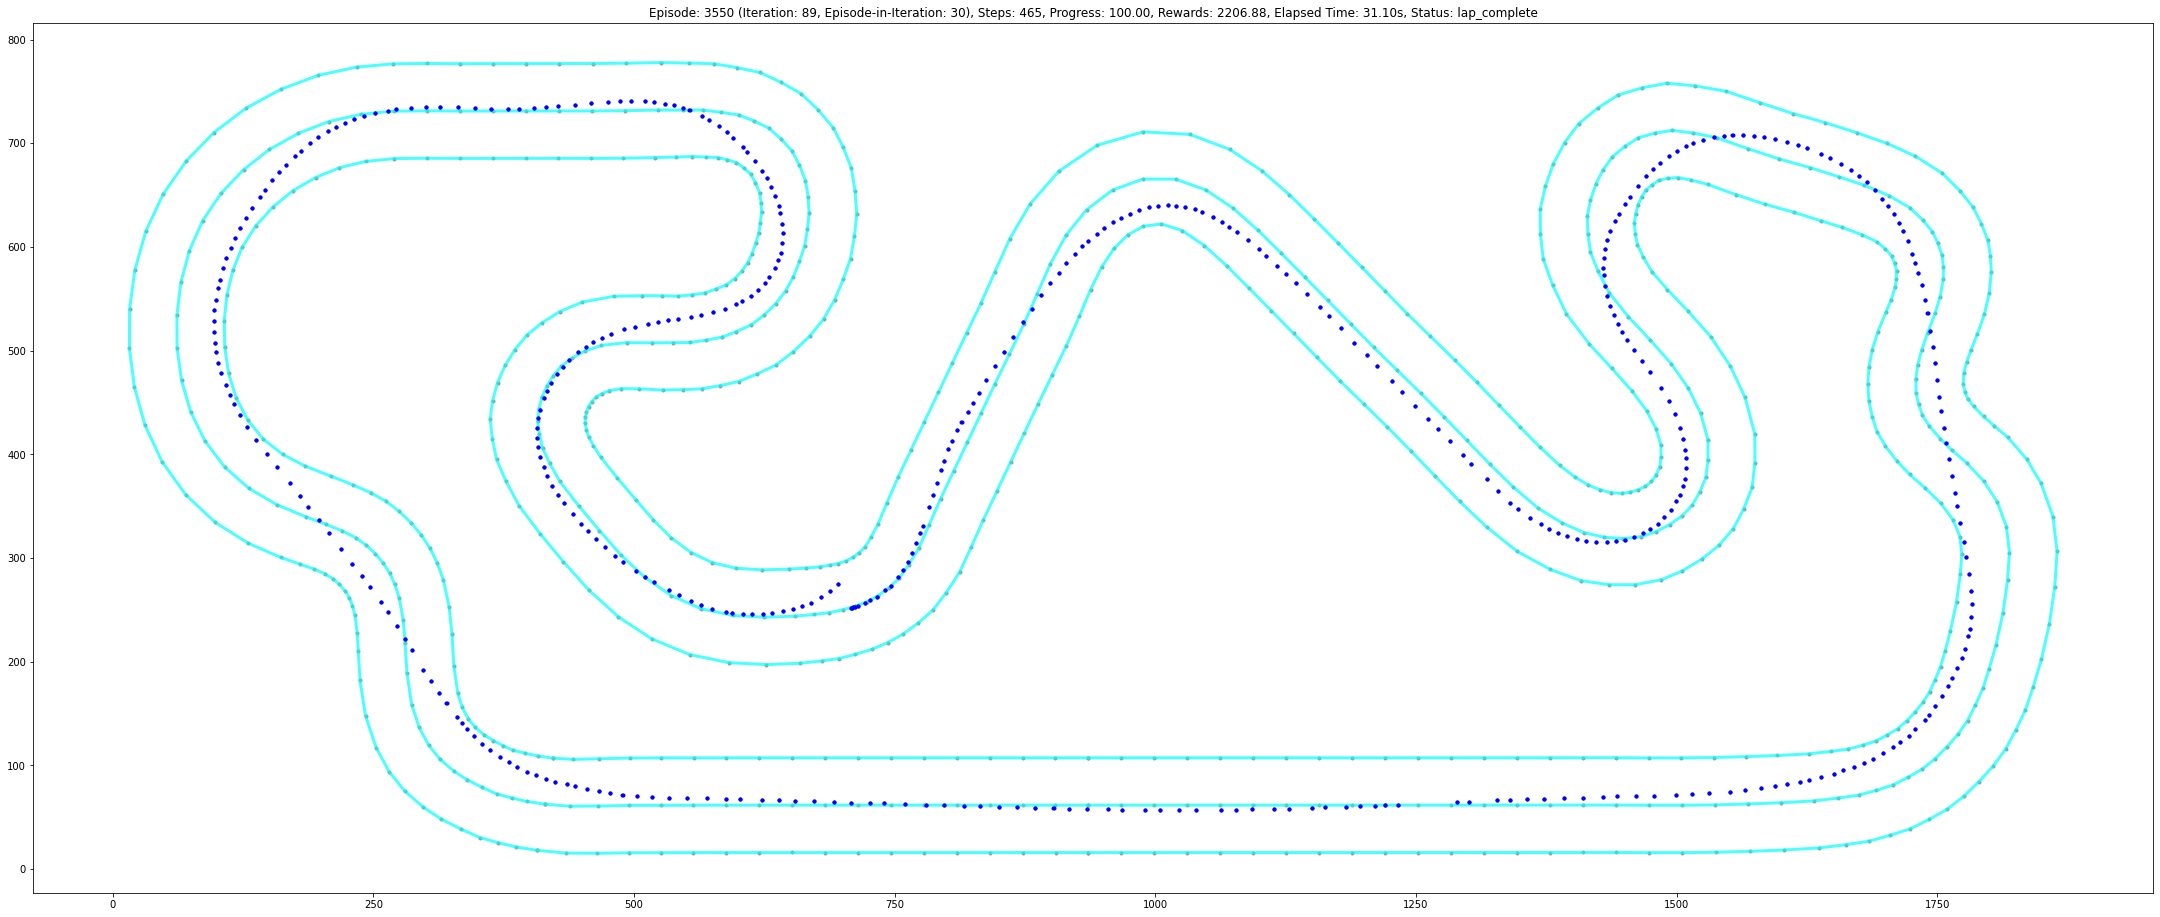

In [113]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset)

# Plot the Vectors of the Steps Taken Throughout the Fastest Lap
For any given step:
- Blue arrow indicates the HEADING of the car
- Green arrow indicates that the car is steering LEFT
- Yellow arrow indicates that the car is steering STRAIGHT
- Red arrow indicate that the car is steering RIGHT
- The length of each arrow indicates the relative speed of the car

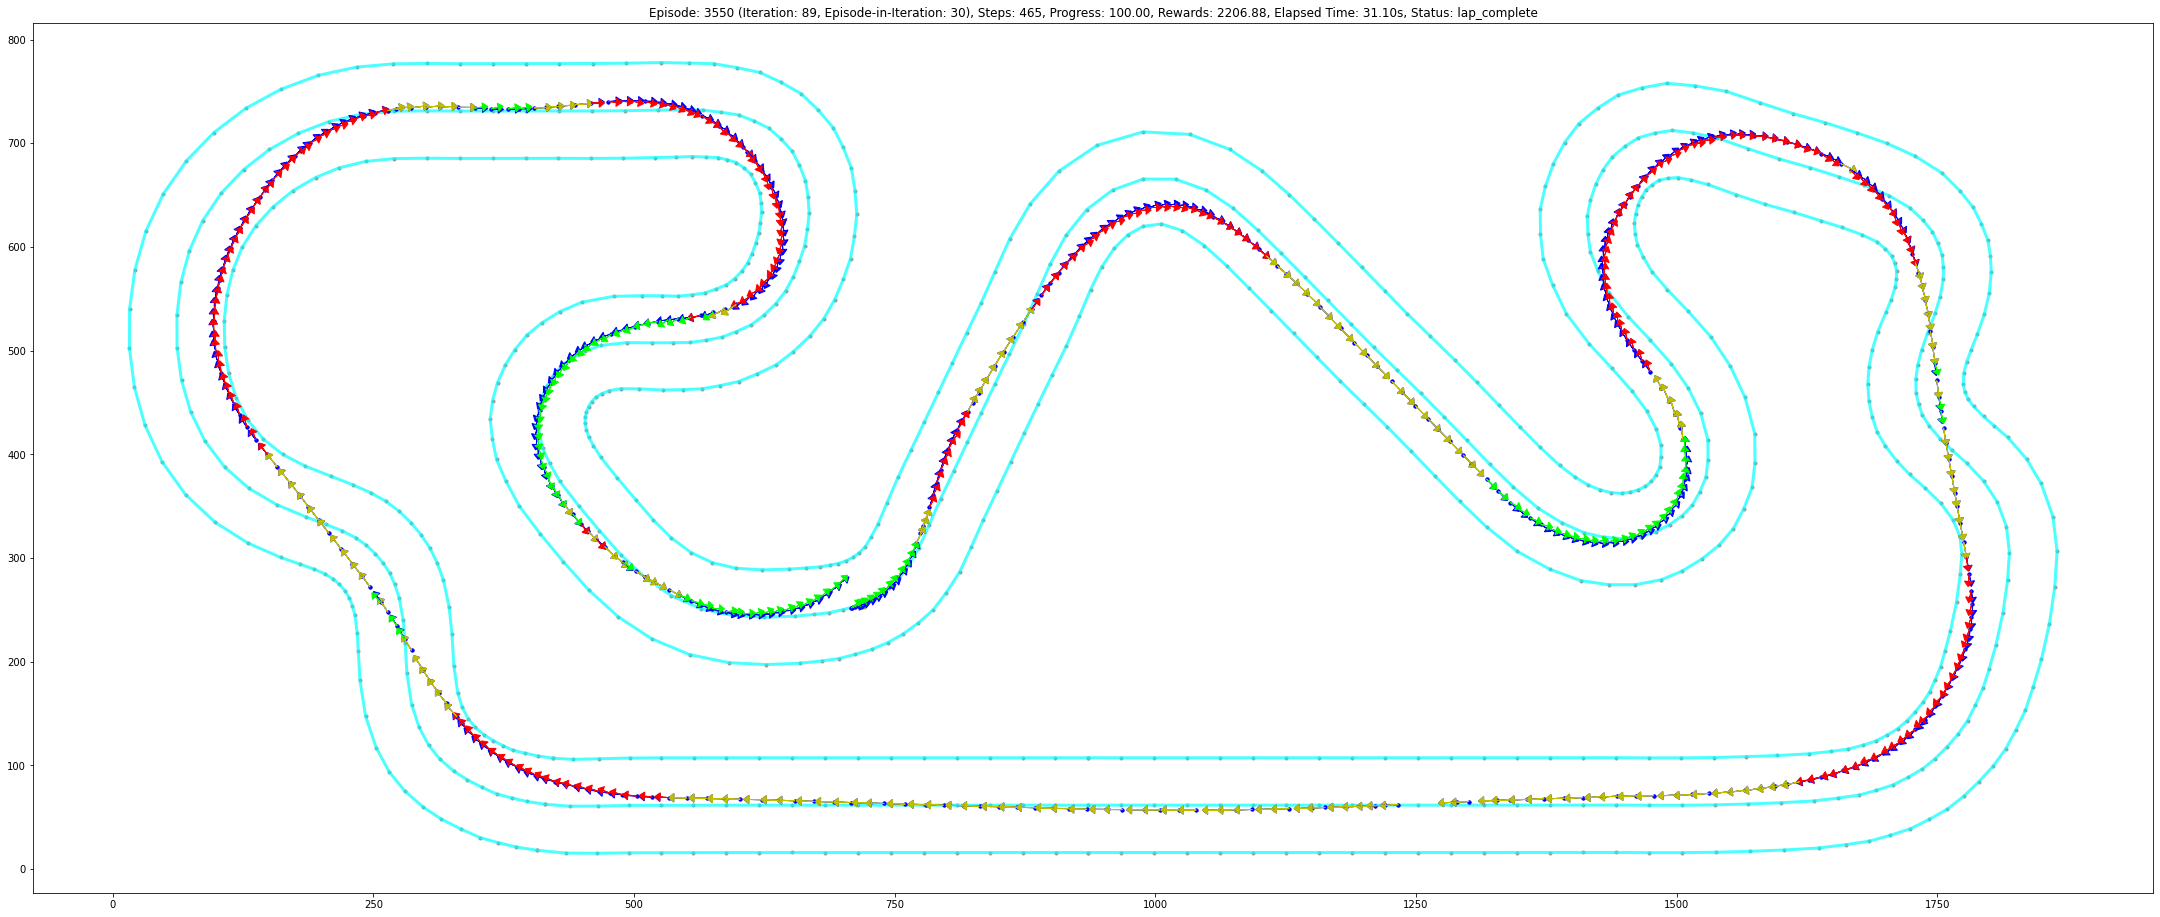

In [114]:
if sim_df_episodes_fastest_full_lap['episode'].count() > 0:
    fig = plot_top_laps(sim_df_episodes_fastest_full_lap['episode'].values, len(sim_df_episodes_fastest_full_lap), x_offset, y_offset, True, True)

In [115]:
print('Done!')

Done!
